In [1]:
!nvidia-smi

Thu Dec 28 21:37:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0               63W / 300W|      0MiB / 81920MiB |     21%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import os

import numpy as np
from custom_stable_video_diffusion_pipeline import CustomStableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.utils.torch_utils import randn_tensor
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.spatial.transform import Rotation as R
from co3d.dataset.data_types import load_dataclass_jgzip, FrameAnnotation
from typing import List
from co3d.dataset.data_types import (
    load_dataclass_jgzip, FrameAnnotation, SequenceAnnotation
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from PIL import Image
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import SGDRegressor

from numpy.linalg import norm
import itertools

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Don't run

In [1]:
!nvidia-smi

Sun Dec 24 07:54:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0               63W / 300W|      0MiB / 81920MiB |     21%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import numpy as np
from custom_stable_video_diffusion_pipeline import CustomStableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
import cv2

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pwd

'/work/ececis_research/peace/dino-diffusion/stable-video-diffusion'

In [3]:

pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
# Load the conditioning image
# image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/svd/rocket.png?download=true")
image = load_image("/work/ececis_research/peace/dino-diffusion/dino-stable-diffusion/data/dog_6.jpeg")
feat_images = [image] * 25
image = image.resize((1024, 576))

generator = torch.manual_seed(42)
output, extracted_features = pipe(image, decode_chunk_size=8, generator=generator, num_inference_steps=1,feat_images= feat_images)
frames = output.frames[0]

export_to_video(frames, "generated.mp4", fps=7)

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


  0%|                                                                                                                                                   | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


'generated.mp4'

In [2]:
features_uncond , features_cond = extracted_features.chunk(2)
# move to cpu and turn to float32
features_uncond = features_uncond.cpu().float()
features_cond = features_cond.cpu().float()
features_uncond.shape, features_cond.shape

(torch.Size([25, 320, 72, 128]), torch.Size([25, 320, 72, 128]))

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Custom TorchPCA class as defined in your code
class TorchPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = X.mean(dim=0)
        unbiased = X - self.mean_.unsqueeze(0)
        U, S, V = torch.pca_lowrank(unbiased, q=self.n_components, center=False, niter=4)
        self.components_ = V.T
        self.singular_values_ = S
        return self

    def transform(self, X):
        t0 = X - self.mean_.unsqueeze(0)
        projected = t0 @ self.components_.T
        return projected


def pca(image_feats_list, dim=3, fit_pca=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_pca is None:
            F.interpolate(tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return feats.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_pca is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    if fit_pca is None:
        # fit_pca = PCA(n_components=dim, svd_solver='arpack').fit(np.nan_to_num(x.detach().numpy()))
        fit_pca = TorchPCA(n_components=dim).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        # x_red = torch.from_numpy(fit_pca.transform(flatten(feats)))
        x_red = fit_pca.transform(flatten(feats))
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_pca

def show_feature_map(features, index):
    # Ensure features are in float32
    features = features.float()

    # Flatten the features for PCA
    B, C, H, W = features.shape
    flattened_features = features.view(B, C, H * W).permute(0, 2, 1).reshape(B * H * W, C)

    # Initialize and fit TorchPCA
    pca = TorchPCA(n_components=3)
    pca.fit(flattened_features)

    # Transform features using PCA
    pca_features = pca.transform(flattened_features)

    # Normalize the PCA features
    scaler = MinMaxScaler(clip=True)
    scaler.fit(pca_features)
    normalized_pca_features = scaler.transform(pca_features)

    # Reshape back to image format and select the specified index
    reshaped_pca_features = normalized_pca_features.reshape(B, H, W, 3).transpose(0, 3, 1, 2)
    selected_features = reshaped_pca_features[index]

    # Plot the PCA-transformed features as an image
    plt.imshow(selected_features.transpose(1, 2, 0))
    plt.show()

# Example usage
# features_uncond is a PyTorch tensor of shape [25, 1280, 9, 16]
show_feature_map(features_uncond, 0)
show_feature_map(features_cond, 0)


## Loading CO3D (Don't run)

In [6]:
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"

In [7]:
from typing import List
from co3d.dataset.data_types import (
    load_dataclass_jgzip, FrameAnnotation, SequenceAnnotation
)
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)
category_sequence_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/sequence_annotations.jgz", List[SequenceAnnotation]
)

In [8]:
category_frame_annotations[0]

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    

In [15]:
sequence_name = '106_12648_23157'
sequenceid_to_frame_annotations[sequence_name][0].viewpoint.T
sequenceid_to_frame_annotations[sequence_name][0].sequence_name

'106_12648_23157'

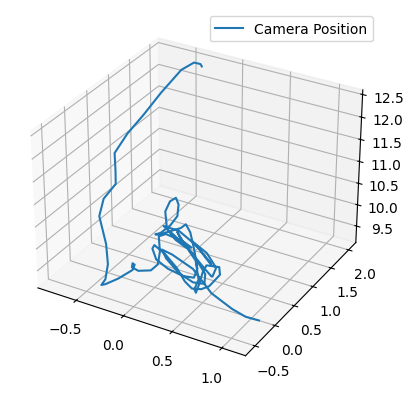

In [25]:
ax = plt.figure().add_subplot(projection='3d')

points = np.array(([f.viewpoint.T for f in sequenceid_to_frame_annotations[sequence_name]]))
ax.plot(points[:, 0], points[:, 1], points[:, 2], label='Camera Position')
ax.legend()

plt.show()

## Training a linear regression model to predict CO3D camera pose from SVD extracted features

### Extracting features

In [2]:
# debug flags
output_videos = True # set to true if you want to output the videos from running SVD 
num_inference_steps = 25 # set to 25 to render the full denoising schedule 
run_one_vid = True # set True to extract features and possibly render only the first 25 frames

In [15]:
# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image
    

# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 24  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False
for i in range(0, num_frames, chunk_size):
    # Create a chunk of frames including the first frame
    chunk_annotations = [first_frame_annotation] + sequenceid_to_frame_annotations[selected_sequence_name][i:i + chunk_size]
    if len(chunk_annotations) < chunk_size:
        break

    # Extract camera positions and orientations for the chunk
    chunk_camera_positions = []
    chunk_camera_orientations = []

    for ann in chunk_annotations:
        # ... [same code as before for extracting T and R]
        T = ann.viewpoint.T
        R_matrix = np.array(ann.viewpoint.R)
        euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=True)

        chunk_camera_positions.append(T)
        chunk_camera_orientations.append(euler_angles)

    # Load and preprocess images for the chunk
    chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]

    print(f"dbg: {len(chunk_feat_images)}")

    # Extract features using Stable Video Diffusion model for the chunk
    # Extract features with the pipeline
    
    output, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images)
    _, features_cond = extracted_features.chunk(2)
    chunk_features = features_cond.cpu().float().numpy()

    if output_videos: 
        frames = output.frames[0]
        export_to_video(frames, f"outputs/CO3D/generated_{i+1}.mp4", fps=7)
        print(f"saved output at outputs/CO3D/generated_{i+1}.mp4")

    # Append to overall lists
    
    
    if not first_chunk_processed:
        all_camera_positions.extend(chunk_camera_positions)
        all_camera_orientations.extend(chunk_camera_orientations)
        all_features.extend(chunk_features)
        first_chunk_processed = True
    else:
        # For subsequent chunks, skip the first frame's features
        all_camera_positions.extend(chunk_camera_positions[1:])
        all_camera_orientations.extend(chunk_camera_orientations[1:])
        all_features.extend(chunk_features[1:]) # Assuming chunk_features is a list of features for the chunk
    if run_one_vid: 
        break

# Convert to numpy arrays for further processing
all_camera_positions = np.array(all_camera_positions)
all_camera_orientations = np.array(all_camera_orientations)
all_features = np.array(all_features)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']
dbg: 25


  0%|                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  4%|█████▍                                                                                                                                   | 1/25 [00:02<00:50,  2.10s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  8%|██████████▉                                                                                                                              | 2/25 [00:03<00:42,  1.85s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 12%|████████████████▍                                                                                                                        | 3/25 [00:05<00:39,  1.77s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 16%|█████████████████████▉                                                                                                                   | 4/25 [00:07<00:36,  1.74s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 20%|███████████████████████████▍                                                                                                             | 5/25 [00:08<00:34,  1.72s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 24%|████████████████████████████████▉                                                                                                        | 6/25 [00:10<00:32,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 28%|██████████████████████████████████████▎                                                                                                  | 7/25 [00:12<00:30,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 32%|███████████████████████████████████████████▊                                                                                             | 8/25 [00:13<00:28,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 36%|█████████████████████████████████████████████████▎                                                                                       | 9/25 [00:15<00:27,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 40%|██████████████████████████████████████████████████████▍                                                                                 | 10/25 [00:17<00:25,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 44%|███████████████████████████████████████████████████████████▊                                                                            | 11/25 [00:18<00:23,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 12/25 [00:20<00:22,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 52%|██████████████████████████████████████████████████████████████████████▋                                                                 | 13/25 [00:22<00:20,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 56%|████████████████████████████████████████████████████████████████████████████▏                                                           | 14/25 [00:24<00:18,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 15/25 [00:25<00:16,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                 | 16/25 [00:27<00:15,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 17/25 [00:29<00:13,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18/25 [00:30<00:11,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 19/25 [00:32<00:10,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20/25 [00:34<00:08,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21/25 [00:35<00:06,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22/25 [00:37<00:05,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23/25 [00:39<00:03,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24/25 [00:41<00:01,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.71s/it]


saved output at outputs/CO3D/generated_1.mp4


In [13]:
selected_sequence_name

'106_12648_23157'

In [5]:
all_features.shape, all_camera_positions.shape, all_camera_orientations.shape

((97, 1280, 9, 16), (97, 3), (97, 3))

### Sanity check for embeddings

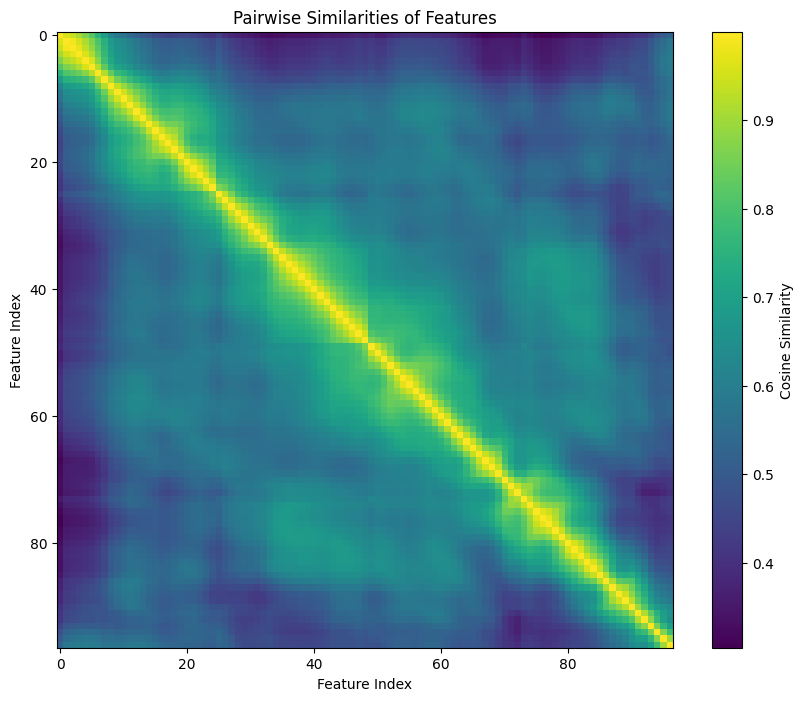

In [7]:
# Assuming 'all_features' is a numpy array of shape (num_samples, num_features, height, width)
# Flatten the features to be of shape (num_samples, num_features * height * width)
flattened_features = all_features.reshape(all_features.shape[0], -1)

# Calculate cosine similarity between all pairs of flattened tensors
similarities = cosine_similarity(flattened_features)

# Plot the pairwise similarities
plt.figure(figsize=(10, 8))
plt.imshow(similarities, cmap='viridis', interpolation='none')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Similarities of Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()


### Sanity check for interpolating between frames using SVD

#### With masking 

In [2]:
# debug flags
output_videos = True # set to true if you want to output the videos from running SVD 
num_inference_steps = 25# set to 25 to render the full denoising schedule 
run_one_vid = True # set True to extract features and possibly render only the first 25 frames
mask_latents_randomly = 0.8 # e.g., .5=50% of the frames in each chunk
mask_latents_range = None

In [3]:
# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image


    

# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 24  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False



for i in range(0, num_frames, chunk_size):
    # Create a chunk of frames including the first frame
    chunk_annotations = [first_frame_annotation] + sequenceid_to_frame_annotations[selected_sequence_name][i:i + chunk_size]
    if len(chunk_annotations) < chunk_size:
        break

    # Extract camera positions and orientations for the chunk
    chunk_camera_positions = []
    chunk_camera_orientations = []

    for ann in chunk_annotations:
        # ... [same code as before for extracting T and R]
        T = ann.viewpoint.T
        R_matrix = np.array(ann.viewpoint.R)
        euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=True)

        chunk_camera_positions.append(T)
        chunk_camera_orientations.append(euler_angles)

    # Load and preprocess images for the chunk
    chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]

    print(f"dbg: {len(chunk_feat_images)}")

    # Extract features using Stable Video Diffusion model for the chunk
    # Extract features with the pipeline
    
    output, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images, mask_latents_randomly=mask_latents_randomly, mask_latents_range=mask_latents_range)
    _, features_cond = extracted_features.chunk(2)
    chunk_features = features_cond.cpu().float().numpy()

    if output_videos: 
        frames = output.frames[0]
        export_to_video(frames, f"outputs/CO3D/generated_{i+1}.mp4", fps=7)
        print(f"saved output at outputs/CO3D/generated_{i+1}.mp4")

    # Append to overall lists
    
    
    if not first_chunk_processed:
        all_camera_positions.extend(chunk_camera_positions)
        all_camera_orientations.extend(chunk_camera_orientations)
        all_features.extend(chunk_features)
        first_chunk_processed = True
    else:
        # For subsequent chunks, skip the first frame's features
        all_camera_positions.extend(chunk_camera_positions[1:])
        all_camera_orientations.extend(chunk_camera_orientations[1:])
        all_features.extend(chunk_features[1:]) # Assuming chunk_features is a list of features for the chunk
    if run_one_vid: 
        break

# Convert to numpy arrays for further processing
all_camera_positions = np.array(all_camera_positions)
all_camera_orientations = np.array(all_camera_orientations)
all_features = np.array(all_features)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']
dbg: 25
dbg: masking latents randomly


  0%|                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])


  4%|█████▍                                                                                                                                   | 1/25 [00:02<01:04,  2.69s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])
amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  8%|██████████▉                                                                                                                              | 2/25 [00:04<00:48,  2.10s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 12%|████████████████▍                                                                                                                        | 3/25 [00:06<00:42,  1.91s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 16%|█████████████████████▉                                                                                                                   | 4/25 [00:07<00:38,  1.83s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 20%|███████████████████████████▍                                                                                                             | 5/25 [00:09<00:35,  1.78s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 24%|████████████████████████████████▉                                                                                                        | 6/25 [00:11<00:33,  1.75s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 28%|██████████████████████████████████████▎                                                                                                  | 7/25 [00:12<00:31,  1.73s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 32%|███████████████████████████████████████████▊                                                                                             | 8/25 [00:14<00:29,  1.72s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 36%|█████████████████████████████████████████████████▎                                                                                       | 9/25 [00:16<00:27,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 40%|██████████████████████████████████████████████████████▍                                                                                 | 10/25 [00:17<00:25,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 44%|███████████████████████████████████████████████████████████▊                                                                            | 11/25 [00:19<00:23,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 12/25 [00:21<00:22,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 52%|██████████████████████████████████████████████████████████████████████▋                                                                 | 13/25 [00:23<00:20,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 56%|████████████████████████████████████████████████████████████████████████████▏                                                           | 14/25 [00:24<00:18,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 15/25 [00:26<00:17,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                 | 16/25 [00:28<00:15,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 17/25 [00:29<00:13,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18/25 [00:31<00:11,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 19/25 [00:33<00:10,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20/25 [00:34<00:08,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21/25 [00:36<00:06,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22/25 [00:38<00:05,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23/25 [00:40<00:03,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24/25 [00:41<00:01,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:43<00:00,  1.74s/it]


saved output at outputs/CO3D/generated_1.mp4


## Train Classifier

#### Split 80/20 train/test

In [ ]:
# Determine the split index
split_index = int(len(all_features) * 0.8)

# Split the features and labels
X_train = all_features[:split_index]
y_train = all_camera_positions[:split_index]
X_test = all_features[split_index:]
y_test = all_camera_positions[split_index:]

# Apply Global Average Pooling (GAP)
gap_features_train = torch.mean(torch.tensor(X_train), dim=[2, 3])
gap_features_test = torch.mean(torch.tensor(X_test), dim=[2, 3])

# Linear Regression model
regressor = LinearRegression()
regressor.fit(gap_features_train, y_train)

# Evaluate the model on both training and testing sets
train_predictions = regressor.predict(gap_features_train)
test_predictions = regressor.predict(gap_features_test)

# Calculate MSE for both sets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


#### Split odd/even train/test

In [7]:


# Split the features and labels
X_train = all_features[::2]
y_train = all_camera_positions[::2]
X_test = all_features[1::2]
y_test = all_camera_positions[1::2]

# Apply Global Average Pooling (GAP)
gap_features_train = torch.mean(torch.tensor(X_train), dim=[2, 3])
gap_features_test = torch.mean(torch.tensor(X_test), dim=[2, 3])

# Linear Regression model
regressor = LinearRegression()
regressor.fit(gap_features_train, y_train)

# Evaluate the model on both training and testing sets
train_predictions = regressor.predict(gap_features_train)
test_predictions = regressor.predict(gap_features_test)

# Calculate MSE for both sets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


Training Mean Squared Error: 1.6200948382937602e-12
Testing Mean Squared Error: 0.0050337489269797545


#### Plotting results

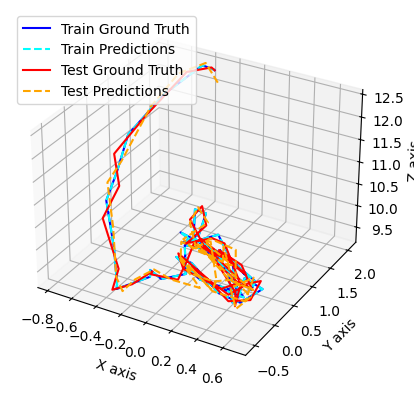

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the ground truth for the training set
ax.plot(y_train[:, 0], y_train[:, 1], y_train[:, 2], color='blue', label='Train Ground Truth', linestyle='-')

# Plotting the predictions for the training set
ax.plot(train_predictions[:, 0], train_predictions[:, 1], train_predictions[:, 2], color='cyan', label='Train Predictions', linestyle='dashed')

# Plotting the ground truth for the testing set
ax.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2], color='red', label='Test Ground Truth', linestyle='-')

# Plotting the predictions for the testing set
ax.plot(test_predictions[:, 0], test_predictions[:, 1], test_predictions[:, 2], color='orange', label='Test Predictions', linestyle='dashed')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

plt.show()


## Training linear regressor across multiple scenes

In [3]:
# debug flags
output_videos = False # set to true if you want to output the videos from running SVD 
num_inference_steps = 1 # set to 25 to render the full denoising schedule 
run_one_vid = False # set True to extract features and possibly render only the first 25 frames
mask_latents_randomly = None # e.g., .5=50% of the frames in each chunk
mask_latents_range = None

In [5]:
!nvidia-smi

Thu Dec 28 21:55:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   33C    P0               44W / 300W|      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [6]:

# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image
    
def compute_relative_position(position1, position2):
    """ Compute the relative position from one pose to another """
    position1 = np.array(position1)
    position2 = np.array(position2)
    relative_position = position2 - position1
    return relative_position


# Prepare data for training
X = []
y = []


# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 25  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False

# Get a list of all sequence names
all_sequence_names = list(sequenceid_to_frame_annotations.keys())

# Determine the split index for 80% training and 20% testing
split_index = int(len(all_sequence_names) * 0.2)

test_split_index = int(split_index * 0.2) + split_index

# Split the sequence names into training and testing sets
train_sequence_names = all_sequence_names[:split_index]
test_sequence_names = all_sequence_names[split_index:test_split_index]

# Initialize the SGDRegressor for incremental learning
regressor = SGDRegressor(max_iter=1, tol=None, learning_rate='constant', eta0=0.001)

# Function to process scenes (to be used for both training and testing)
def process_scenes(scene_names, regressor=None, training=True, num_samples_per_scene=50):
    X, y = [], []
    for sequence_name in tqdm(scene_names, desc="Processing Scenes"):
        annotations = sequenceid_to_frame_annotations[sequence_name]
        num_frames = len(annotations)

        # Randomly select a start index for a chunk within the scene
        if num_frames > chunk_size:
            i = random.randint(0, num_frames - chunk_size)
        else:
            continue  # Skip scenes that don't have enough frames


        chunk_annotations = annotations[i:i + chunk_size]
        chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]
        _, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images)
        _, chunk_features = extracted_features.chunk(2)
        chunk_features = chunk_features.cpu().float().numpy()
        cur_samples_per_scene = 0
        for j in range(len(chunk_features)):
            for k in range(j + 1, len(chunk_features)):
                position1 = chunk_annotations[j].viewpoint.T
                position2 = chunk_annotations[k].viewpoint.T
                relative_position = compute_relative_position(position1, position2)

                combined_features = np.concatenate((chunk_features[j].flatten(), chunk_features[k].flatten()))
                X.append(combined_features)
                y.append(relative_position)
                cur_samples_per_scene+=1
            #     if cur_samples_per_scene == num_samples_per_scene: 
            #         continue
            # if cur_samples_per_scene == num_samples_per_scene: 
            #         continue
                

                # if training:
                #     # Incrementally fit the model
                #     regressor.partial_fit(combined_features.reshape(1, -1), relative_position.reshape(1, -1))
                # else:
                #     X.append(combined_features)
                #     y.append(relative_position)

    return X, y

# Process training scenes
X_train, y_train = process_scenes(train_sequence_names, regressor=regressor, training=True)

# Process testing scenes
X_test, y_test = process_scenes(test_sequence_names, training=False)

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Processing Scenes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:02<00:00, 10.22s/it]


In [6]:
len(X_train)

18300

In [9]:
!nvidia-smi

Thu Dec 21 00:35:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   51C    P0               75W / 300W|  60143MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor

# Initialize the base SGDRegressor
sgd_regressor = SGDRegressor(max_iter=1, tol=None, learning_rate='constant', eta0=0.01)

# Wrap it in a MultiOutputRegressor for multi-target regression
multioutput_regressor = MultiOutputRegressor(sgd_regressor)

# Define the batch size for incremental learning
batch_size = 100  # You can adjust this based on your memory capacity

Training multioutput regressor: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [01:12<00:00,  2.51it/s]


In [16]:
# Manually iterate over the training data in batches
for i in tqdm(range(0, len(X_train), batch_size), desc="Training multioutput regressor"):
    batch_X_train = X_train[i:i + batch_size]
    batch_y_train = y_train[i:i + batch_size]
    multioutput_regressor.partial_fit(batch_X_train, batch_y_train)



Training multioutput regressor: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [01:13<00:00,  2.50it/s]


In [10]:
_X_test=X_test
_y_test=y_test


In [ ]:
X_test= X_train

In [11]:
len(_X_test), len(_y_test)

(3600, 3600)

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_model_in_batches(model, X_data, y_data, batch_size):
    mse_total = 0
    total_samples = 0

    for i in tqdm(range(0, len(X_data), batch_size)):
        batch_X = X_data[i:i + batch_size]
        batch_y = y_data[i:i + batch_size]

        predictions = model.predict(batch_X)
        mse_batch = mean_squared_error(batch_y, predictions)

        mse_total += mse_batch * len(batch_X)
        total_samples += len(batch_X)

    return mse_total / total_samples


In [17]:

# Define the batch size for evaluation
eval_batch_size = 100  # Adjust as needed

# Evaluate the training data
train_mse = evaluate_model_in_batches(multioutput_regressor, X_train, y_train, eval_batch_size)
print("Training Mean Squared Error:", train_mse)

# Evaluate the testing data
test_mse = evaluate_model_in_batches(multioutput_regressor, X_test, y_test, eval_batch_size)
print("Testing Mean Squared Error:", test_mse)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:42<00:00,  4.26it/s]


Training Mean Squared Error: 1.893711386860359e+36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.90it/s]

Testing Mean Squared Error: 2.315192331366082e+36


In [22]:
len(X_train)

18300

In [6]:
def RTA(pred, gt):
    """
    Calculate the Relative Translation Accuracy (RTA) using NumPy.
    Args:
        pred (ndarray): Predicted translation vectors.
        gt (ndarray): Ground truth translation vectors.
    Returns:
        ndarray: The RTA for each pair of predictions and ground truths.
    """
    
    # Compute the cosine similarity and use arccos to get the angular difference
    cosine_similarity = np.sum(pred * gt, axis=1)
    angular_difference = np.arccos(np.clip(cosine_similarity, -1.0, 1.0))  # Clipping for numerical stability
    
    # Convert radians to degrees
    angular_difference_degrees = np.degrees(angular_difference)
    return angular_difference_degrees

def RTA_at_threshold(rta_degrees, threshold):
    """
    Calculate the percentage of RTA below the given threshold using NumPy.
    Args:
        rta_degrees (ndarray): RTA values in degrees.
        threshold (float): Threshold angle in degrees.
    Returns:
        float: The percentage of RTA values below the threshold.
    """
    below_threshold = rta_degrees < threshold
    percentage_below_threshold = np.mean(below_threshold) * 100
    return percentage_below_threshold

def mAA(rta_degrees, thresholds):
    """
    Calculate the mean Average Accuracy (mAA) over a range of thresholds using NumPy.
    Args:
        rta_degrees (ndarray): RTA values in degrees.
        thresholds (list): List of threshold angles in degrees.
    Returns:
        float: The mAA value.
    """
    mAA_values = [RTA_at_threshold(rta_degrees, tau) for tau in thresholds]
    return sum(mAA_values) / len(mAA_values)


In [7]:
def normalize_positions_np(positions):
    """
    Normalize the position vectors using L2 norm.

    Args:
    positions (np.ndarray): Position vectors, shape (N, D) where N is the number of vectors and D is the dimensionality.

    Returns:
    np.ndarray: Normalized position vectors.
    """
    norms = np.linalg.norm(positions, axis=1, keepdims=True)
    normalized_positions = positions / norms
    return normalized_positions

In [11]:
np.array(small_y_train).shape

(4000, 3)

In [9]:
from sklearn.linear_model import LinearRegression

small_X_train = X_train[:4000]
small_y_train = np.array(y_train[:4000])
small_y_train_norm = normalize_positions_np(small_y_train)
print(small_y_train_norm.shape)
# calculate_stats(small_y_train, "small_y_train")
# calculate_stats(small_y_train_norm, "small_y_train_norm")

# Test with a simple linear regression model
simple_regressor = LinearRegression()
simple_regressor.fit(small_X_train, small_y_train)

# Evaluate the simple model
simple_train_predictions = simple_regressor.predict(small_X_train)
simple_train_mse = mean_squared_error(small_y_train, simple_train_predictions)
print("Simple Model Training Mean Squared Error:", simple_train_mse)
simple_train_mse = mean_squared_error(small_y_train_norm, simple_train_predictions)
print("Simple Model Training Mean Squared Error norm:", simple_train_mse)


(4000, 3)
Simple Model Training Mean Squared Error: 1.778799314580941e-11
Simple Model Training Mean Squared Error norm: 0.15997988689383272


In [47]:
small_y_train[:10]

array([[-0.12478542,  0.08585413,  0.09140301],
       [-0.18816896,  0.1941896 ,  0.35098457],
       [-0.17826109,  0.28526197,  0.5103426 ],
       [-0.1389937 ,  0.33674031,  0.57317066],
       [-0.0962798 ,  0.29950445,  0.47852421],
       [-0.05187164,  0.16672484,  0.35638618],
       [-0.06200533,  0.01909428,  0.26316833],
       [-0.10660692, -0.10066266,  0.16925907],
       [-0.14389773, -0.14284097,  0.14552021],
       [-0.13895008, -0.06572614,  0.07425022]])

In [57]:
small_y_train_norm[:10]*0.175886525

array([[-0.12406411,  0.08535786,  0.09087466],
       [-0.07469857,  0.07708862,  0.13933247],
       [-0.05129619,  0.08208663,  0.14685556],
       [-0.03599691,  0.08720978,  0.14844106],
       [-0.02957049,  0.09198704,  0.14696952],
       [-0.02298919,  0.07389143,  0.15794817],
       [-0.0402361 ,  0.01239054,  0.17077353],
       [-0.08373307, -0.07906423,  0.13294243],
       [-0.10141226, -0.10066751,  0.10255571],
       [-0.14316785, -0.06772123,  0.07650406]])

In [56]:
np.linalg.norm(small_y_train[:10], axis = 1)

array([0.17690914, 0.44306583, 0.61122907, 0.67914497, 0.57267629,
       0.39686138, 0.27104764, 0.22393445, 0.2495721 , 0.17070485])

In [50]:
np.linalg.norm(small_y_train_norm[:10], axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
small_y_test = np.array(y_test[:4000])
small_y_test_norm = normalize_positions_np(small_y_test)

In [20]:
train_predictions = simple_regressor.predict(small_X_train)
train_mse = mean_squared_error(small_y_train, train_predictions)
print("Training Subset Mean Squared Error:", train_mse)

Training Subset Mean Squared Error: 1.778799314580941e-11


In [17]:
test_predictions = simple_regressor.predict(X_test[:4000])
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

Testing Subset Mean Squared Error: 0.6266537995244965


In [23]:
rta_diffs = RTA(train_predictions, small_y_train)
RTA_at_threshold(rta_diffs, 5), RTA_at_threshold(rta_diffs, 15), RTA_at_threshold(rta_diffs, 30)

(27.375, 28.125, 30.4)

In [18]:
rta_diffs = RTA(test_predictions, small_y_test)
RTA_at_threshold(rta_diffs, 5), RTA_at_threshold(rta_diffs, 15), RTA_at_threshold(rta_diffs, 30)

(1.8888888888888888, 1.972222222222222, 2.25)

In [44]:
rta_diffs.max()

89.98535487397199

In [44]:

def calculate_stats(data, label):
    data_norm = norm(data)
    data_mean = np.mean(data, axis=0)
    data_median = np.median(data, axis=0)
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)

    print(f"Stats for {label}:")
    print(f"Norm: {data_norm}")
    print(f"Mean: {data_mean}")
    print(f"Median: {data_median}")
    print(f"Min: {data_min}")
    print(f"Max: {data_max}\n")
    
def plot_3d_subset(y_true, y_pred, start_index=0, subset_size=25):
    """
    Plots a 3D comparison of true values and predictions for a specified subset.

    :param y_true: Array of true values.
    :param y_pred: Array of predicted values.
    :param start_index: Starting index for the subset to plot.
    :param subset_size: Number of data points in the subset to plot.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    calculate_stats(y_true_subset, "Ground Truth")
    calculate_stats(y_pred_subset, "Predictions")


    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the ground truth for the subset
    ax.plot(y_true_subset[:, 0], y_true_subset[:, 1], y_true_subset[:, 2], color='red', label='Ground Truth', linestyle='-')

    # Plotting the predictions for the subset
    ax.plot(y_pred_subset[:, 0], y_pred_subset[:, 1], y_pred_subset[:, 2], color='orange', label='Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"3D Plot from index {start_index} to {end_index}")
    plt.show()



def plot_3d_subset_scaled(y_true, y_pred, start_index=0, subset_size=25):
    from sklearn.preprocessing import MinMaxScaler
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    # Min-Max scaling both the ground truth and predictions
    scaler = MinMaxScaler()
    y_true_subset_scaled = scaler.fit_transform(y_true_subset)
    y_pred_subset_scaled = 4* scaler.transform(y_pred_subset)

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the scaled ground truth for the subset
    ax.plot(y_true_subset_scaled[:, 0], y_true_subset_scaled[:, 1], y_true_subset_scaled[:, 2], color='red', label='Scaled Ground Truth', linestyle='-')

    # Plotting the scaled predictions for the subset
    ax.plot(y_pred_subset_scaled[:, 0], y_pred_subset_scaled[:, 1], y_pred_subset_scaled[:, 2], color='orange', label='Scaled Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"Scaled 3D Plot from index {start_index} to {end_index}")
    plt.show()



In [26]:
len(X_test)

3600

range test data: 3300 3600
Testing Subset Mean Squared Error: 0.06528116073677544
Stats for Ground Truth:
Norm: 1.4299607595932542
Mean: [-0.22566808  0.03945857  0.03584297]
Median: [-0.21350093  0.04807876  0.0357883 ]
Min: [-0.42160749 -0.00435805 -0.14853382]
Max: [-0.00408879  0.07646161  0.18880987]

Stats for Predictions:
Norm: 1.5664896965026855
Mean: [ 0.04685971  0.1192513  -0.26993743]
Median: [ 0.05950214  0.10875659 -0.24922687]
Min: [-0.07343207  0.0170415  -0.4150482 ]
Max: [ 0.16446966  0.18955442 -0.15716371]



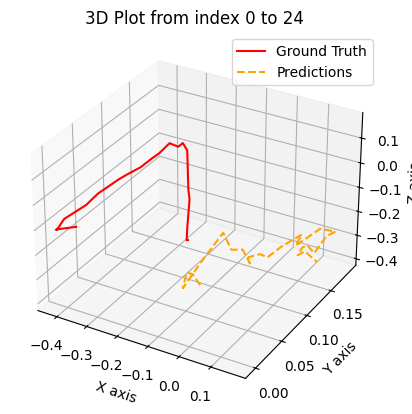

In [48]:
# Evaluate the model on the testing subset

j = 11
print("range test data:", j*300,(j*300)+300)
small_X_test = X_test[j*300:(j*300)+300]
small_y_test = y_test[j*300:(j*300)+300]


test_predictions = simple_regressor.predict(small_X_test)
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

plot_3d_subset(small_y_test, test_predictions, start_index=0, subset_size=24)

range test data: 3300 3600
Testing Subset Mean Squared Error: 0.0430270912649841
Stats for Ground Truth:
Norm: 1.1249452535846227
Mean: [-0.10288206 -0.03920202 -0.14310684]
Median: [-0.11808816 -0.02933575 -0.18027496]
Min: [-0.28902664 -0.07812095 -0.25799084]
Max: [ 0.02475946 -0.0009529   0.02655029]

Stats for Predictions:
Norm: 1.6715894937515259
Mean: [-0.17155693  0.25501636  0.00034705]
Median: [-0.18430254  0.28234196  0.02240884]
Min: [-0.29895967  0.07159884 -0.21567811]
Max: [-0.00752327  0.3693742   0.09430096]



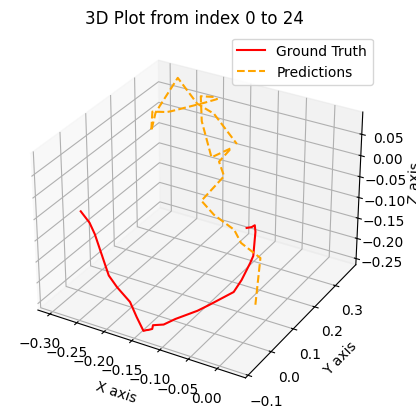

In [45]:
# Evaluate the model on the testing subset

j = 11
print("range test data:", j*300,(j*300)+300)
small_X_test = X_test[j*300:(j*300)+300]
small_y_test = y_test[j*300:(j*300)+300]


test_predictions = simple_regressor.predict(small_X_test)
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

plot_3d_subset(small_y_test, test_predictions, start_index=0, subset_size=24)

range test data: 3300 3600
Testing Subset Mean Squared Error: 0.013978020788075024
Stats for Ground Truth:
Norm: 2.5559167015519693
Mean: [-0.14972662 -0.31699641 -0.34566883]
Median: [-0.17655686 -0.366561   -0.35717106]
Min: [-0.22246211 -0.4138025  -0.50819492]
Max: [-0.02062613 -0.03158396 -0.05865526]

Stats for Predictions:
Norm: 1.5051189661026
Mean: [-0.09955552 -0.255286   -0.02122906]
Median: [-0.10238623 -0.29687566 -0.02586754]
Min: [-0.17039238 -0.39875844 -0.07009995]
Max: [ 0.00369531 -0.03354251  0.0698455 ]



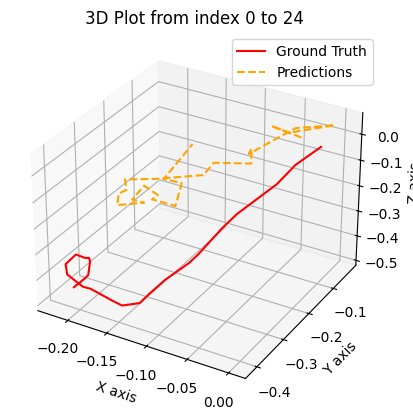

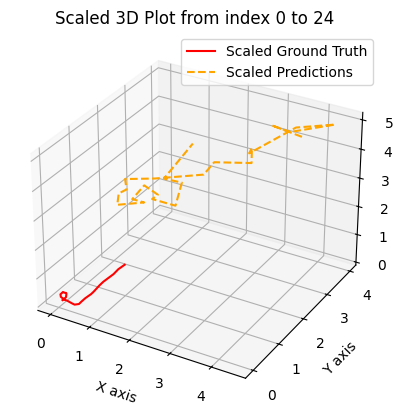

In [121]:
# Evaluate the model on the testing subset

j = 11
print("range test data:", j*300,(j*300)+300)
small_X_test = X_test[j*300:(j*300)+300]
small_y_test = y_test[j*300:(j*300)+300]


test_predictions = simple_regressor.predict(small_X_test)
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

plot_3d_subset(small_y_test, test_predictions, start_index=0, subset_size=24)
plot_3d_subset_scaled(small_y_test, test_predictions, start_index=0, subset_size=24)

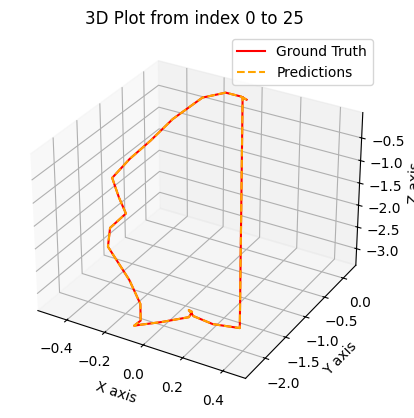

In [23]:
plot_3d_subset(small_y_train[:200], train_predictions, start_index=0, subset_size=25)

## Sanity checks

In [7]:
# ... [Your existing code for loading data and defining functions] ...

# Function to process chunks and create embeddings
def process_and_embed_scenes(scene_names):
    chunk_embeddings = []
    chunk_mappings = []
    for sequence_name in tqdm(scene_names, desc="Processing Scenes"):
        annotations = sequenceid_to_frame_annotations[sequence_name]
        for i in range(0, len(annotations), 25):
            chunk_annotations = annotations[i:i+25]
            if len(chunk_annotations) < 25:
                continue  # Skip if the chunk is not complete
            chunk_images = [preprocess_image(ann) for ann in chunk_annotations]
            _, extracted_features = pipe(chunk_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_images)
            _, chunk_features = extracted_features.chunk(2)
            chunk_embeddings.append(chunk_features.cpu().numpy().flatten())
            chunk_mappings.append(sequence_name)
    return np.array(chunk_embeddings), chunk_mappings

# Process chunks and create embeddings
all_chunk_embeddings, all_chunk_mappings = process_and_embed_scenes(random.sample(all_sequence_names, 5))


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Processing Scenes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:26<00:00, 41.37s/it]


In [8]:
sampled_chunk_embeddings, sampled_chunk_mappings = all_chunk_embeddings, all_chunk_mappings

In [11]:
# Number of images per chunk
images_per_chunk = 25

# Reshape the embeddings to separate each image's features
# The new shape will be (total_chunks * images_per_chunk, features_per_image)
total_chunks = sampled_chunk_embeddings.shape[0]
features_per_image = int(sampled_chunk_embeddings.shape[1] / images_per_chunk)
expanded_embeddings = sampled_chunk_embeddings.reshape(total_chunks * images_per_chunk, features_per_image)
expanded_chunk_mappings = [scene for scene in sampled_chunk_mappings for _ in range(25)]



In [13]:
expanded_embeddings.shape, len(expanded_chunk_mappings)

((500, 184320), 500)

### Sanity check: TSNE plots

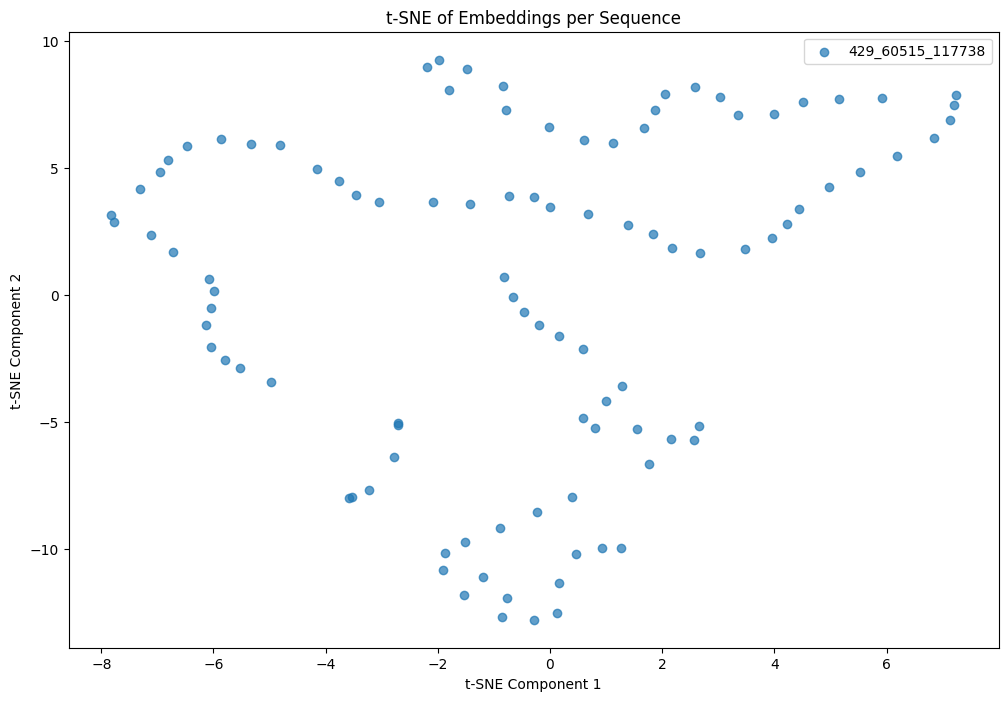

In [24]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming 'expanded_embeddings' and 'expanded_chunk_mappings' are defined as before
# unique_sequences = sorted(set(expanded_chunk_mappings))  # Get unique sequences
# tsne_results = {}  # Dictionary to store t-SNE results per sequence

# # Perform t-SNE for each sequence
# for seq in unique_sequences:
#     # Filter embeddings for the current sequence
#     seq_embeddings = expanded_embeddings[np.array(expanded_chunk_mappings) == seq, :]
#     # Apply t-SNE to these embeddings
#     tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
#     tsne_results[seq] = tsne.fit_transform(seq_embeddings)

# Plotting
plt.figure(figsize=(12, 8))
for idx, (seq, embeddings) in enumerate(tsne_results.items()):
    if idx != 4: 
        continue
    plt.scatter(embeddings[:, 0], embeddings[:, 1], label=seq, alpha=0.7)
    

plt.title('t-SNE of Embeddings per Sequence')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()  # Add a legend if you want to label each sequence
plt.show()


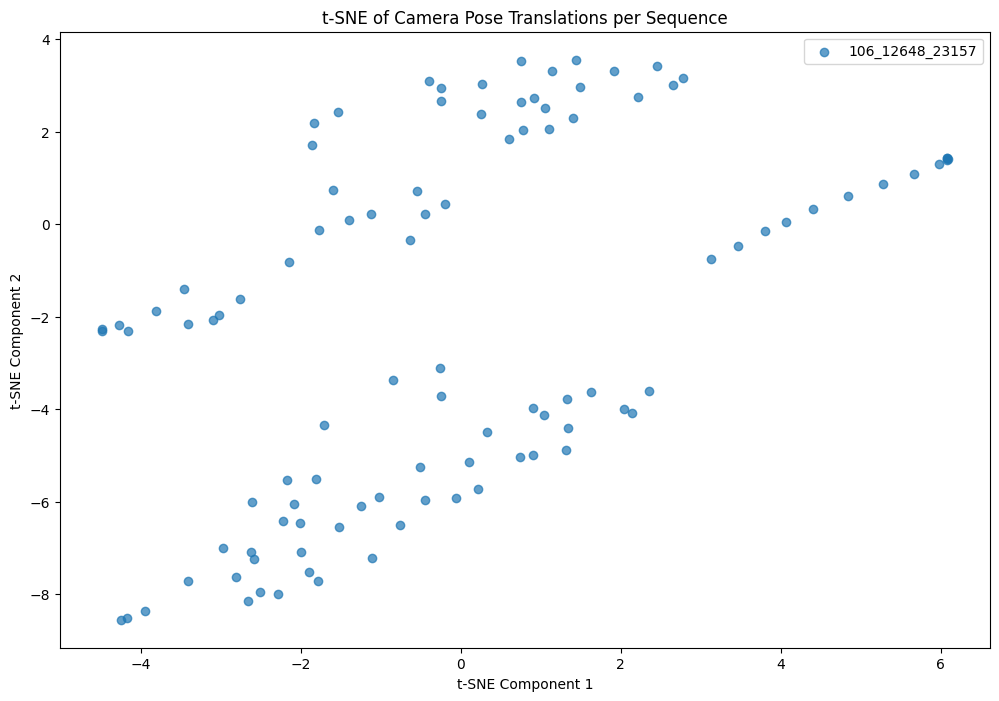

In [43]:
# # Assuming 'sequenceid_to_frame_annotations' is a dictionary containing lists of FrameAnnotations for each sequence
# tsne_camera_positions = {}  # Dictionary to store t-SNE results per sequence

# # Perform t-SNE for each sequence's camera positions
# for seq_id, annotations in sequenceid_to_frame_annotations.items():
#     # Extract camera positions for the current sequence
#     camera_positions = np.array([ann.viewpoint.T for ann in annotations])
#     # Apply t-SNE to these camera positions
#     tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
#     tsne_camera_positions[seq_id] = tsne.fit_transform(camera_positions)

# Plotting
plt.figure(figsize=(12, 8))
for idx, (seq_id, positions_2d) in enumerate(tsne_camera_positions.items()):
    if idx != 0: 
        continue
    plt.scatter(positions_2d[:, 0], positions_2d[:, 1], label=seq_id, alpha=0.7)

plt.title('t-SNE of Camera Pose Translations per Sequence')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()  # Add a legend if you want to label each sequence
plt.show()


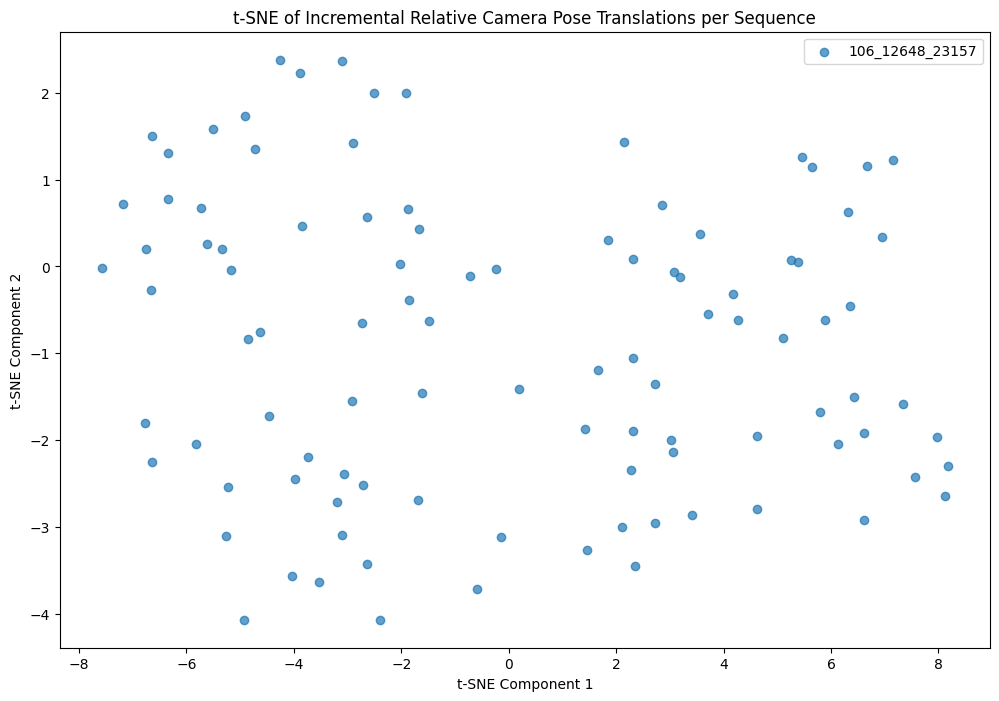

In [60]:
# # Assuming 'sequenceid_to_frame_annotations' is a dictionary containing lists of FrameAnnotations for each sequence
# tsne_incremental_camera_positions = {}  # Dictionary to store t-SNE results per sequence

# # Perform t-SNE for each sequence's incremental relative camera positions
# for seq_id, annotations in sequenceid_to_frame_annotations.items():
#     # Extract camera positions for the current sequence
#     camera_positions = np.array([ann.viewpoint.T for ann in annotations])
#     # Compute relative positions between consecutive frames
#     relative_camera_positions = np.diff(camera_positions, axis=0)
#     # Apply t-SNE to these relative camera positions
#     tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
#     tsne_incremental_camera_positions[seq_id] = tsne.fit_transform(relative_camera_positions)

# Plotting
plt.figure(figsize=(12, 8))
for idx, (seq_id, positions_2d) in enumerate(tsne_incremental_camera_positions.items()):
    if idx != 0: 
        continue
    plt.scatter(positions_2d[:, 0], positions_2d[:, 1], label=seq_id, alpha=0.7)

plt.title('t-SNE of Incremental Relative Camera Pose Translations per Sequence')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()  # Add a legend if you want to label each sequence
plt.show()


Stats for Ground Truth:
Norm: 103.53021237060236
Mean: [ 0.16170335  0.13115671 10.20133616]
Median: [ 0.19964539 -0.03501969  9.96608448]
Min: [-0.77607447 -0.54671383  9.17889977]
Max: [ 1.09666502  2.0227282  12.53205395]

Stats for Predictions:
Norm: 103.53021237060236
Mean: [ 0.16170335  0.13115671 10.20133616]
Median: [ 0.19964539 -0.03501969  9.96608448]
Min: [-0.77607447 -0.54671383  9.17889977]
Max: [ 1.09666502  2.0227282  12.53205395]



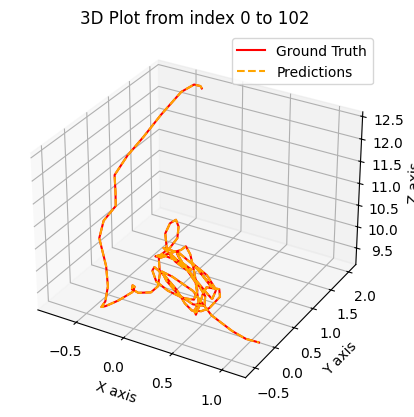

sequence id: 106_12648_23157


In [61]:
for idx, (seq_id, annotations) in enumerate(sequenceid_to_frame_annotations.items()):
    if idx != 0: 
        continue
    # Extract camera positions for the current sequence
    camera_positions = np.array([ann.viewpoint.T for ann in annotations])
    # Apply t-SNE to these camera positions
    plot_3d_subset(camera_positions, camera_positions, 0, len(camera_positions))
    print("sequence id:", seq_id)

### Sanity check: KNN

In [ ]:

# Initialize and fit NearestNeighbors with expanded embeddings
neigh = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neigh.fit(expanded_embeddings)


dbg:  415_57140_110207 206_21818_45959
dbg:  415_57140_110207 206_21818_45959
dbg:  415_57140_110207 206_21818_45959
dbg:  415_57140_110207 206_21818_45959
dbg:  415_57140_110207 206_21818_45959


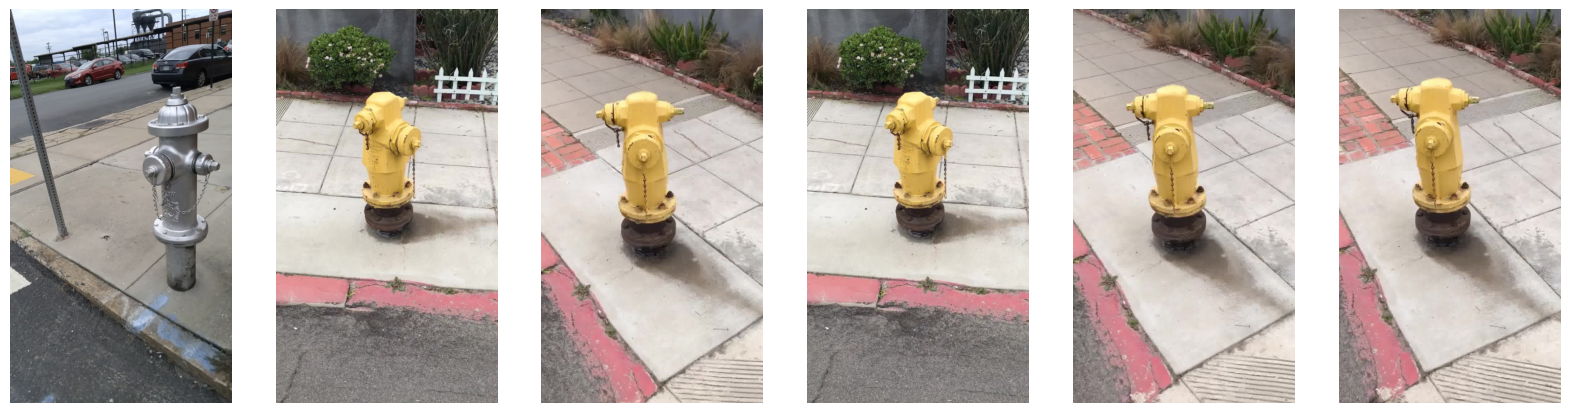

In [94]:

# Function to find KNN for sampled scenes, ensuring different scenes
def find_knn_for_sampled_scenes(query_index, k=5):
    distances, indices = neigh.kneighbors([expanded_embeddings[query_index]], n_neighbors=len(expanded_embeddings))
    different_scene_indices = []
    query_scene = sampled_chunk_mappings[int(query_index / images_per_chunk)]
    for idx in indices[0]:
        neighbor_scene = sampled_chunk_mappings[int(idx / images_per_chunk)]
        if neighbor_scene != query_scene:
            print("dbg: ", neighbor_scene, query_scene)
            different_scene_indices.append(idx)
            if len(different_scene_indices) == k:
                break
    different_scene_indices = [query_index] + different_scene_indices
    return different_scene_indices

# Select a random image from the expanded embeddings
random_image_index = random.randint(0, len(expanded_embeddings) - 1)
knn_image_indices = find_knn_for_sampled_scenes(random_image_index, k=5)

# Retrieve first image paths from each nearest neighbor
knn_image_paths = [f"{DATA_DIR}/{sequenceid_to_frame_annotations[sampled_chunk_mappings[int(idx / images_per_chunk)]][idx % images_per_chunk].image.path}" for idx in knn_image_indices]

# Function to display images
def display_images(image_paths):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 10))
    for ax, img_path in zip(axes, image_paths):
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

# Display the images of the KNN results
display_images(knn_image_paths)

### Sanity check: differences in latent vector. Checking for similar directionality across multiple scenes

In [98]:
len(sampled_chunk_mappings)

20

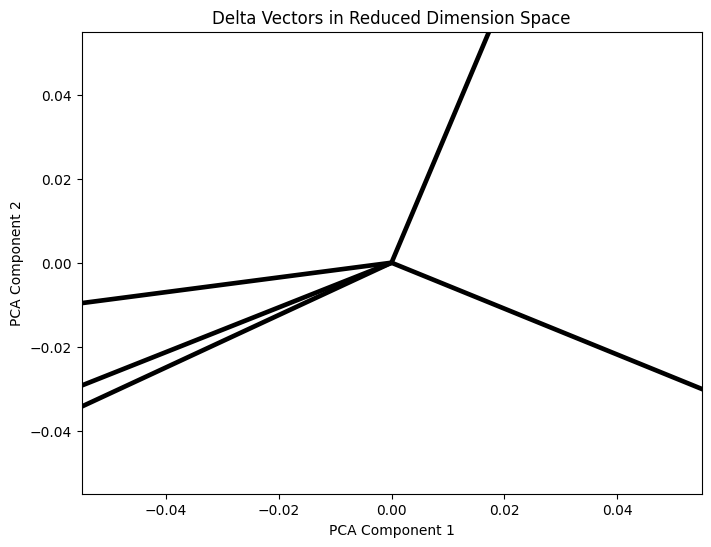

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Step 2: Calculate Delta Vectors for Each Scene
delta_vectors = {}
for scene in set(expanded_chunk_mappings):
    scene_indices = [i for i, x in enumerate(expanded_chunk_mappings) if x == scene]
    scene_features = expanded_embeddings[scene_indices, :]
    deltas = np.diff(scene_features, axis=0)
    delta_vectors[scene] = deltas

# Step 3: Compare Delta Vectors Across Scenes
# For simplicity, compare the first delta of each scene with each other
first_deltas = np.array([deltas[0] for deltas in delta_vectors.values() if deltas.size > 0])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_deltas = pca.fit_transform(first_deltas)

# Visualize
plt.figure(figsize=(8, 6))
plt.quiver(np.zeros(reduced_deltas.shape[0]), np.zeros(reduced_deltas.shape[0]), 
           reduced_deltas[:, 0], reduced_deltas[:, 1], angles='xy', scale_units='xy', scale=1)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Delta Vectors in Reduced Dimension Space')
plt.show()

# Cosine similarity (optional)
similarity_matrix = cosine_similarity(first_deltas)


In [103]:
import math

In [106]:
# Assuming 'first_deltas' contains the first delta vector for each scene
n = first_deltas.shape[0]
total_cosine_similarity = 0
count = 0
min_cs = float('inf')
max_cs = -float('inf')

for i in range(n):
    for j in range(i + 1, n):
        cosine_sim = cosine_similarity([first_deltas[i]], [first_deltas[j]])[0, 0]
        total_cosine_similarity += cosine_sim
        min_cs = min(min_cs, cosine_sim)
        max_cs = max(max_cs, cosine_sim)
        count += 1

# Compute the average cosine similarity
average_cosine_similarity = total_cosine_similarity / count

print(f"Average Cosine Similarity between Delta Vectors: {average_cosine_similarity:.2f}")
print("min cosine sim: ", min_cs)
print("max cosine sim: ", max_cs)

Average Cosine Similarity between Delta Vectors: 0.55
min cosine sim:  0.4013558132165621
max cosine sim:  0.7277139229722309


In [100]:
import numpy as np

# Assuming 'first_deltas' contains the first delta vector for each scene
# Calculate the angles between each pair of delta vectors
n = first_deltas.shape[0]
angles = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        # Cosine similarity
        cosine_sim = cosine_similarity([first_deltas[i]], [first_deltas[j]])[0, 0]
        # Convert to angle (in radians)
        angle = np.arccos(np.clip(cosine_sim, -1.0, 1.0))
        angles[i, j] = angle
        angles[j, i] = angle  # Symmetric matrix

# Calculate the average angle
average_angle = np.sum(angles) / (n * (n - 1))

# Convert average angle from radians to degrees for easier interpretation
average_angle_degrees = np.degrees(average_angle)

print(f"Average Angle (in degrees) between Delta Vectors: {average_angle_degrees:.2f}")


Average Angle (in degrees) between Delta Vectors: 56.65


## Pytorch training on CO3D

In [3]:
def global_average_pooling(features):
    # Apply GAP to reduce each feature map to a single number per channel
    return F.adaptive_avg_pool2d(features, (1)).view(features.size(0))


DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"

pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)

category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)


pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)



class CO3DDataset(Dataset):
    def __init__(self, scene_annotations, data_dir, pipeline, transform=None, num_samples=25):
        self.scene_annotations = scene_annotations
        self.data_dir = data_dir
        self.pipeline = pipeline
        self.transform = transform
        self.num_samples = num_samples
        self.scene_names = list(scene_annotations.keys())

    def __len__(self):
        return len(self.scene_annotations)

    def __getitem__(self, idx):
        
        scene = self.scene_names[idx]
        annotations = self.scene_annotations[scene]
        
        if len(annotations) < self.num_samples:
            raise ValueError(f"Scene {scene} does not have enough annotations.")
        
        # Randomly sample annotations
        sampled_anns = random.sample(annotations, self.num_samples)

        # Process images and extract features
        imgs, positions = [], []
        for ann in sampled_anns:
            img = self.process_image(ann)
            imgs.append(img)
            positions.append(torch.tensor(ann.viewpoint.T, dtype=torch.float32))

        # Feature extraction with pipeline
        _, extracted_features = self.pipeline(imgs[0], decode_chunk_size=8, generator=torch.manual_seed(42), num_inference_steps=1, feat_images=imgs)
        _, features_cond = extracted_features.chunk(2)
        features = features_cond.cpu().float()

       # Initialize lists for aggregated features and positions
        aggregated_features, aggregated_positions = [], []
    
        # Create all pairs and aggregate features and positions
        for i, j in itertools.combinations(range(self.num_samples), 2):
            relative_pos = positions[j] - positions[i]
            # GAP both features
            gap_features_1, gap_features_2 = global_average_pooling(features[i]), global_average_pooling(features[j])
            features_cat = torch.cat((gap_features_1, gap_features_2), dim = 0)
            # Append to the aggregated lists
            aggregated_features.append(features_cat)
            aggregated_positions.append(relative_pos)
            
        # Convert lists to tensors and reshape to (-1)
        aggregated_features_tensor = torch.stack(aggregated_features).reshape(300, -1)
        aggregated_positions_tensor = torch.stack(aggregated_positions).reshape(300, -1)
    
        return aggregated_features_tensor, aggregated_positions_tensor

    def process_image(self, ann):
        image_path = os.path.join(self.data_dir, ann.image.path)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transforms = Compose([
    Resize(576),
    CenterCrop((576, 1024)),
])

# Create the dataset and dataloader
co3d_dataset = CO3DDataset(sequenceid_to_frame_annotations, DATA_DIR, pipe, transform=transforms)
co3d_dataloader = DataLoader(co3d_dataset, batch_size=1)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


In [4]:
sample_batch = next(iter(co3d_dataloader))
# Assuming the batch returns a list of tuples (features1, features2, relative_pos)
# and each feature tensor has a shape of [num_samples, feature_dim]
sample_feature = sample_batch[0][0][0]  # Get the first feature tensor from the first pair

# Calculate the input size for the model (double the size of a single feature set)
input_size = sample_feature.shape[0]
print("dbg: feature shape", sample_feature.shape)
print("dbg: feature_size: ",input_size)

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


dbg: feature shape torch.Size([2560])
dbg: feature_size:  2560


In [5]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")

# Define a simple linear regression model
class SimpleRegressor(nn.Module):
    def __init__(self, input_size):
        super(SimpleRegressor, self).__init__()
        self.linear = nn.Linear(input_size, 3)  # Predicting 3D relative position

    def forward(self, x):
        return self.linear(x)


# Define and initialize the simple linear regression model with the calculated input size
model = SimpleRegressor(input_size=input_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [6]:

model = model.to(device)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [7]:
 list(iter(model.named_parameters()))

[('linear.weight',
  Parameter containing:
  tensor([[-0.0098, -0.0156, -0.0093,  ...,  0.0051,  0.0083, -0.0102],
          [-0.0039, -0.0051, -0.0085,  ..., -0.0098,  0.0041,  0.0197],
          [ 0.0068,  0.0037, -0.0176,  ..., -0.0008,  0.0130,  0.0028]],
         device='cuda:0', requires_grad=True)),
 ('linear.bias',
  Parameter containing:
  tensor([-0.0035,  0.0098,  0.0073], device='cuda:0', requires_grad=True))]

In [14]:
# train flags

num_epochs = 3

In [15]:
def normalize_positions(positions):
    # L2 normalization (Euclidean norm)
    return F.normalize(positions, p=2, dim=1)


def print_summary(tensor, name, threshold=1e6):
    print(f"Summary for {name}: Mean = {tensor.mean()}, Std = {tensor.std()}, Min = {tensor.min()}, Max = {tensor.max()}")
    if torch.any(tensor.abs() > threshold):
        print(f"Values in {name} exceed threshold {threshold}")

def print_sample(tensor, name, sample_size=10):
    sample = tensor.view(-1)[:sample_size]
    print(f"Sample values from {name}: {sample}")

losses = []
# Training loop with GAP and L2 normalization
for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(tqdm(co3d_dataloader, desc="Training linear pose regression")):
        # Prepare data
        features, relative_pos = batch
        features = features.squeeze().to(device)
        relative_pos = relative_pos.squeeze().to(device)
        
        print(f"dbg: {features.shape=}, {relative_pos.shape=}")
        print(f"dbg: {features.device=}, {relative_pos.device=}")

        # Normalize features and positions
        # norm_features1 = normalize_features(gap_features1)
        # norm_features2 = normalize_features(gap_features2)
        norm_relative_pos = normalize_positions(relative_pos)
    
        # Forward pass
        outputs = model(features)
        
        norm_outputs = normalize_positions(outputs)
        print(f"dbg: {norm_relative_pos.shape=}, {outputs.shape=}, {norm_outputs.shape=}")
        print(f"dbg: {norm_relative_pos.device=}, {outputs.device=}, {norm_outputs.device=}")

        loss = criterion(norm_outputs, norm_relative_pos)
        if torch.isnan(loss):
            print("NaN detected in loss before backward")
            # Additional checks and prints for outputs
            print_summary(outputs, "Outputs")
            print_sample(outputs, "Outputs")
            print_summary(features, "Features")
            print_sample(features, "Features")
            
            continue  # Skip the backward pass for this batch

        if idx % 10 == 0: 
            losses.append(loss)
        
        print("Loss: ", loss)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Assuming 'model' is your model and 'optimizer' is your optimizer

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    # you can add more items to the checkpoint if needed, like epoch number, loss, etc.
}

torch.save(checkpoint, 'model_checkpoint.pth')


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   0%|▎                                                                                                      | 1/307 [00:09<50:15,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5994, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|▋                                                                                                      | 2/307 [00:20<51:50, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7588, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█                                                                                                      | 3/307 [00:30<51:55, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6364, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█▎                                                                                                     | 4/307 [00:40<51:41, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6186, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|█▋                                                                                                     | 5/307 [00:51<51:33, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5990, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██                                                                                                     | 6/307 [01:01<51:26, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6879, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██▎                                                                                                    | 7/307 [01:11<50:43, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6772, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|██▋                                                                                                    | 8/307 [01:21<50:47, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6942, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███                                                                                                    | 9/307 [01:32<51:05, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6660, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███▎                                                                                                  | 10/307 [01:42<50:53, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7327, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▋                                                                                                  | 11/307 [01:52<50:39, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6308, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▉                                                                                                  | 12/307 [02:02<50:28, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6153, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|████▎                                                                                                 | 13/307 [02:13<50:43, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6789, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▋                                                                                                 | 14/307 [02:23<50:19, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6524, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▉                                                                                                 | 15/307 [02:34<50:27, 10.37s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7316, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|█████▎                                                                                                | 16/307 [02:44<49:39, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6669, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▋                                                                                                | 17/307 [02:54<49:33, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7362, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▉                                                                                                | 18/307 [03:04<48:48, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5695, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|██████▎                                                                                               | 19/307 [03:14<48:24, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6267, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▋                                                                                               | 20/307 [03:24<48:40, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6981, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▉                                                                                               | 21/307 [03:34<48:23, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6648, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▎                                                                                              | 22/307 [03:44<48:14, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5932, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▋                                                                                              | 23/307 [03:55<48:15, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6740, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|███████▉                                                                                              | 24/307 [04:05<48:26, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6257, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▎                                                                                             | 25/307 [04:15<47:53, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6982, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▋                                                                                             | 26/307 [04:25<47:20, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6845, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|████████▉                                                                                             | 27/307 [04:35<47:26, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6425, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▎                                                                                            | 28/307 [04:45<46:38, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6275, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▋                                                                                            | 29/307 [04:55<46:29, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5856, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|█████████▉                                                                                            | 30/307 [05:05<46:43, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7416, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▎                                                                                           | 31/307 [05:15<46:27, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6933, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▋                                                                                           | 32/307 [05:25<46:02, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6291, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|██████████▉                                                                                           | 33/307 [05:35<45:46, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6601, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▎                                                                                          | 34/307 [05:46<45:57, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6271, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▋                                                                                          | 35/307 [05:56<46:08, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6937, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|███████████▉                                                                                          | 36/307 [06:06<45:56, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6394, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▎                                                                                         | 37/307 [06:16<45:35, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6685, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▋                                                                                         | 38/307 [06:26<45:10, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6597, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|████████████▉                                                                                         | 39/307 [06:36<45:13, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7202, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▎                                                                                        | 40/307 [06:46<44:50, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6759, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▌                                                                                        | 41/307 [06:57<45:09, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8233, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|█████████████▉                                                                                        | 42/307 [07:07<44:46, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6886, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▎                                                                                       | 43/307 [07:17<44:24, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6417, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▌                                                                                       | 44/307 [07:27<44:08, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6235, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|██████████████▉                                                                                       | 45/307 [07:37<43:42, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6248, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▎                                                                                      | 46/307 [07:46<43:17,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6643, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▌                                                                                      | 47/307 [07:56<43:03,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6289, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|███████████████▉                                                                                      | 48/307 [08:07<43:18, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6871, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▎                                                                                     | 49/307 [08:17<43:37, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6523, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▌                                                                                     | 50/307 [08:27<43:48, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6909, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|████████████████▉                                                                                     | 51/307 [08:37<43:11, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7196, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▎                                                                                    | 52/307 [08:47<43:03, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6918, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▌                                                                                    | 53/307 [08:57<42:28, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7001, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|█████████████████▉                                                                                    | 54/307 [09:08<42:54, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6636, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▎                                                                                   | 55/307 [09:18<42:17, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7325, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▌                                                                                   | 56/307 [09:27<41:44,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6819, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|██████████████████▉                                                                                   | 57/307 [09:37<41:15,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6796, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▎                                                                                  | 58/307 [09:47<41:38, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6926, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▌                                                                                  | 59/307 [09:58<41:48, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6646, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|███████████████████▉                                                                                  | 60/307 [10:08<41:42, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7202, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▎                                                                                 | 61/307 [10:18<41:17, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6793, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▌                                                                                 | 62/307 [10:28<41:11, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6113, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|████████████████████▉                                                                                 | 63/307 [10:38<41:20, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5969, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▎                                                                                | 64/307 [10:48<41:14, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7179, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▌                                                                                | 65/307 [10:58<40:45, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6511, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▉                                                                                | 66/307 [11:08<40:23, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6683, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▎                                                                               | 67/307 [11:19<40:22, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6769, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▌                                                                               | 68/307 [11:28<39:50, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6261, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▉                                                                               | 69/307 [11:39<39:55, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5974, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▎                                                                              | 70/307 [11:48<39:36, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6494, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▌                                                                              | 71/307 [11:58<39:23, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7641, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▉                                                                              | 72/307 [12:08<39:04,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6393, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▎                                                                             | 73/307 [12:18<38:46,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5875, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▌                                                                             | 74/307 [12:28<38:31,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6192, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▉                                                                             | 75/307 [12:38<38:22,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7058, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▎                                                                            | 76/307 [12:48<38:17,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6136, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▌                                                                            | 77/307 [12:58<38:06,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7069, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▉                                                                            | 78/307 [13:08<37:54,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6399, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▏                                                                           | 79/307 [13:18<37:33,  9.88s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6274, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▌                                                                           | 80/307 [13:28<37:25,  9.89s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6661, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▉                                                                           | 81/307 [13:38<37:48, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7216, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▏                                                                          | 82/307 [13:48<37:39, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6043, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▌                                                                          | 83/307 [13:58<37:39, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6516, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▉                                                                          | 84/307 [14:08<37:09, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5429, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▏                                                                         | 85/307 [14:18<36:57,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6005, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▌                                                                         | 86/307 [14:28<37:19, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7284, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▉                                                                         | 87/307 [14:38<37:00, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6782, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▏                                                                        | 88/307 [14:48<36:48, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6367, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▌                                                                        | 89/307 [14:58<36:21, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5852, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▉                                                                        | 90/307 [15:08<36:06,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6811, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▏                                                                       | 91/307 [15:18<35:52,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6293, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▌                                                                       | 92/307 [15:28<35:35,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7036, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▉                                                                       | 93/307 [15:38<35:24,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8117, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▏                                                                      | 94/307 [15:48<35:22,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6189, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▌                                                                      | 95/307 [15:58<35:09,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6207, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▉                                                                      | 96/307 [16:08<34:58,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7169, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▏                                                                     | 97/307 [16:18<34:45,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5440, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▌                                                                     | 98/307 [16:28<34:42,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8140, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▉                                                                     | 99/307 [16:38<34:27,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4559, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|████████████████████████████████▉                                                                    | 100/307 [16:47<34:13,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5941, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▏                                                                   | 101/307 [16:58<34:15,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6328, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▌                                                                   | 102/307 [17:08<34:32, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6004, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|█████████████████████████████████▉                                                                   | 103/307 [17:18<34:28, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6525, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▏                                                                  | 104/307 [17:28<34:10, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5612, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▌                                                                  | 105/307 [17:39<34:25, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6615, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|██████████████████████████████████▊                                                                  | 106/307 [17:49<34:01, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7829, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▏                                                                 | 107/307 [17:59<33:46, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6429, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▌                                                                 | 108/307 [18:09<33:32, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6682, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|███████████████████████████████████▊                                                                 | 109/307 [18:19<33:01, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6139, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▏                                                                | 110/307 [18:29<33:12, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6614, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▌                                                                | 111/307 [18:39<32:54, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6021, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▊                                                                | 112/307 [18:49<33:03, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6084, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▏                                                               | 113/307 [19:00<32:50, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6121, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▌                                                               | 114/307 [19:10<32:32, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7245, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▊                                                               | 115/307 [19:20<32:35, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5221, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▏                                                              | 116/307 [19:30<32:10, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6762, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▍                                                              | 117/307 [19:40<31:59, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6693, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▊                                                              | 118/307 [19:50<32:04, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7420, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▏                                                             | 119/307 [20:00<31:50, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6086, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▍                                                             | 120/307 [20:11<31:37, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6824, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▊                                                             | 121/307 [20:21<31:20, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6836, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▏                                                            | 122/307 [20:31<31:02, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5888, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▍                                                            | 123/307 [20:41<31:02, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8330, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▊                                                            | 124/307 [20:51<30:53, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8232, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████                                                            | 125/307 [21:01<30:35, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6722, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▍                                                           | 126/307 [21:11<30:27, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6956, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▊                                                           | 127/307 [21:21<30:14, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6823, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████                                                           | 128/307 [21:31<30:05, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4751, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▍                                                          | 129/307 [21:41<29:55, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7629, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▊                                                          | 130/307 [21:51<29:51, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6711, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████                                                          | 131/307 [22:01<29:35, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6247, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▍                                                         | 132/307 [22:12<29:24, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7216, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▊                                                         | 133/307 [22:22<29:14, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7506, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████                                                         | 134/307 [22:32<29:27, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7019, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▍                                                        | 135/307 [22:42<29:07, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7409, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▋                                                        | 136/307 [22:52<28:53, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7001, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████                                                        | 137/307 [23:02<28:40, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5958, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▍                                                       | 138/307 [23:12<28:30, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6360, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▋                                                       | 139/307 [23:22<28:12, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6823, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████                                                       | 140/307 [23:32<28:03, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6864, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▍                                                      | 141/307 [23:43<27:57, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6277, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▋                                                      | 142/307 [23:53<27:44, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7201, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████                                                      | 143/307 [24:03<27:37, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6439, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▎                                                     | 144/307 [24:13<27:28, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6634, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▋                                                     | 145/307 [24:23<27:22, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6651, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████                                                     | 146/307 [24:33<27:11, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6977, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▎                                                    | 147/307 [24:43<27:03, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6756, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▋                                                    | 148/307 [24:54<26:54, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6748, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████                                                    | 149/307 [25:04<27:07, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6989, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▎                                                   | 150/307 [25:14<26:48, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6219, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▋                                                   | 151/307 [25:24<26:29, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6471, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████                                                   | 152/307 [25:35<26:25, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5397, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▎                                                  | 153/307 [25:45<26:06, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6683, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▋                                                  | 154/307 [25:55<25:41, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6656, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▉                                                  | 155/307 [26:05<25:45, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6047, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▎                                                 | 156/307 [26:15<25:38, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6255, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▋                                                 | 157/307 [26:26<25:34, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6829, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▉                                                 | 158/307 [26:36<25:36, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7759, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▎                                                | 159/307 [26:47<25:37, 10.39s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6824, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▋                                                | 160/307 [26:57<25:17, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7630, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▉                                                | 161/307 [27:07<24:45, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6530, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▎                                               | 162/307 [27:17<24:46, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7011, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▋                                               | 163/307 [27:28<24:45, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6021, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▉                                               | 164/307 [27:38<24:22, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7357, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▎                                              | 165/307 [27:48<24:09, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7068, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▌                                              | 166/307 [28:03<27:37, 11.75s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5402, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▉                                              | 167/307 [28:13<26:16, 11.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5540, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▎                                             | 168/307 [28:24<25:32, 11.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6892, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▌                                             | 169/307 [28:34<24:50, 10.80s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7023, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▉                                             | 170/307 [28:44<24:25, 10.70s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6823, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▎                                            | 171/307 [28:55<24:03, 10.61s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6183, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▌                                            | 172/307 [29:05<23:43, 10.54s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6269, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▉                                            | 173/307 [29:15<23:00, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7085, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▏                                           | 174/307 [29:25<22:38, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6218, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▌                                           | 175/307 [29:35<22:27, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6365, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▉                                           | 176/307 [29:45<22:15, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6961, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▏                                          | 177/307 [29:56<22:17, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6512, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▌                                          | 178/307 [30:06<22:07, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6413, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▉                                          | 179/307 [30:16<21:57, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6154, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▏                                         | 180/307 [30:27<21:48, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5724, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▌                                         | 181/307 [30:37<21:21, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6346, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▉                                         | 182/307 [30:47<21:08, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6583, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▏                                        | 183/307 [30:57<21:03, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5479, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▌                                        | 184/307 [31:07<20:59, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6387, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▊                                        | 185/307 [31:18<20:46, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6829, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▏                                       | 186/307 [31:28<20:26, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7104, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▌                                       | 187/307 [31:38<20:11, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6301, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▊                                       | 188/307 [31:48<20:12, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5535, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▏                                      | 189/307 [31:58<19:56, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6192, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▌                                      | 190/307 [32:08<19:49, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6247, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▊                                      | 191/307 [32:19<19:52, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5323, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▏                                     | 192/307 [32:29<19:48, 10.33s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5713, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▍                                     | 193/307 [32:39<19:17, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5410, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▊                                     | 194/307 [32:49<19:16, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6253, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▏                                    | 195/307 [33:00<19:09, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6443, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▍                                    | 196/307 [33:10<18:50, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5479, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▊                                    | 197/307 [33:20<18:47, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6537, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|█████████████████████████████████████████████████████████████████▏                                   | 198/307 [33:30<18:35, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6527, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▍                                   | 199/307 [33:40<18:24, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5564, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▊                                   | 200/307 [33:51<18:08, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5869, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|██████████████████████████████████████████████████████████████████▏                                  | 201/307 [34:01<17:55, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6323, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▍                                  | 202/307 [34:11<17:41, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6466, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▊                                  | 203/307 [34:21<17:31, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6589, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|███████████████████████████████████████████████████████████████████                                  | 204/307 [34:31<17:20, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6353, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▍                                 | 205/307 [34:41<17:07, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7628, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▊                                 | 206/307 [34:51<16:56, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6360, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|████████████████████████████████████████████████████████████████████                                 | 207/307 [35:01<16:42, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6472, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▍                                | 208/307 [35:11<16:33, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6447, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▊                                | 209/307 [35:21<16:28, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6653, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|█████████████████████████████████████████████████████████████████████                                | 210/307 [35:31<16:14, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6029, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▍                               | 211/307 [35:41<16:05, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6594, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▋                               | 212/307 [35:51<15:59, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6177, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|██████████████████████████████████████████████████████████████████████                               | 213/307 [36:01<15:44, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6811, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▍                              | 214/307 [36:11<15:34, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7082, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▋                              | 215/307 [36:21<15:23, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6374, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|███████████████████████████████████████████████████████████████████████                              | 216/307 [36:31<15:14, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6095, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▍                             | 217/307 [36:41<15:04, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6752, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▋                             | 218/307 [36:52<15:04, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5390, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|████████████████████████████████████████████████████████████████████████                             | 219/307 [37:02<15:01, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6091, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▍                            | 220/307 [37:13<14:57, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6443, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▋                            | 221/307 [37:23<14:47, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6768, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|█████████████████████████████████████████████████████████████████████████                            | 222/307 [37:33<14:36, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7080, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▎                           | 223/307 [37:44<14:23, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7148, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▋                           | 224/307 [37:54<14:19, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6622, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|██████████████████████████████████████████████████████████████████████████                           | 225/307 [38:04<13:58, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6918, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▎                          | 226/307 [38:14<13:48, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6677, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▋                          | 227/307 [38:24<13:34, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6727, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|███████████████████████████████████████████████████████████████████████████                          | 228/307 [38:35<13:26, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6499, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▎                         | 229/307 [38:45<13:14, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6492, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▋                         | 230/307 [38:55<13:10, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6172, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▉                         | 231/307 [39:05<12:57, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6917, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▎                        | 232/307 [39:16<12:50, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6955, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▋                        | 233/307 [39:26<12:32, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7516, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▉                        | 234/307 [39:36<12:27, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4733, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▎                       | 235/307 [39:47<12:29, 10.41s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
NaN detected in loss before backward
Summary for Outputs: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Outputs: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward0>)
Summary for Features: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Features: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▋                       | 236/307 [39:57<12:07, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6404, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▉                       | 237/307 [40:07<11:52, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7044, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▎                      | 238/307 [40:17<11:38, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6191, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▋                      | 239/307 [40:27<11:23, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5836, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▉                      | 240/307 [40:37<11:10, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6181, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▎                     | 241/307 [40:46<10:59, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6898, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▌                     | 242/307 [40:56<10:49, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6923, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▉                     | 243/307 [41:06<10:38,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6131, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|████████████████████████████████████████████████████████████████████████████████▎                    | 244/307 [41:17<10:35, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5616, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▌                    | 245/307 [41:27<10:27, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6457, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▉                    | 246/307 [41:37<10:12, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7189, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 247/307 [41:47<10:04, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6186, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 248/307 [41:57<09:59, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5027, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 249/307 [42:07<09:48, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6224, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 250/307 [42:18<09:42, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7633, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 251/307 [42:28<09:33, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5305, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 252/307 [42:38<09:19, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6067, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 253/307 [42:48<09:04, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7211, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 254/307 [42:58<08:53, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5358, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 255/307 [43:08<08:42, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5673, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|████████████████████████████████████████████████████████████████████████████████████▏                | 256/307 [43:19<08:39, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5315, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▌                | 257/307 [43:29<08:32, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4183, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▉                | 258/307 [43:39<08:25, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5591, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 259/307 [43:50<08:13, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6274, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 260/307 [44:00<07:59, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5630, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 261/307 [44:10<07:52, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6188, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 262/307 [44:20<07:42, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6854, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 263/307 [44:30<07:27, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5818, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 264/307 [44:41<07:21, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6584, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 265/307 [44:51<07:13, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6588, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 266/307 [45:02<07:03, 10.33s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6413, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 267/307 [45:12<06:53, 10.33s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5327, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 268/307 [45:22<06:40, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6695, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 269/307 [45:32<06:30, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6791, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 270/307 [45:42<06:16, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5860, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 271/307 [45:53<06:09, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7641, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 272/307 [46:03<05:56, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6008, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 273/307 [46:13<05:46, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5241, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 274/307 [46:23<05:35, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6587, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 275/307 [46:33<05:26, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7799, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 276/307 [46:44<05:19, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6006, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 277/307 [46:54<05:11, 10.38s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6106, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 278/307 [47:05<05:01, 10.38s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6445, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 279/307 [47:15<04:48, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6631, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|████████████████████████████████████████████████████████████████████████████████████████████         | 280/307 [47:25<04:37, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6361, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 281/307 [47:35<04:25, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6788, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 282/307 [47:45<04:14, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6911, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 283/307 [47:56<04:04, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7271, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 284/307 [48:06<03:54, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7277, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 285/307 [48:16<03:44, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5924, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 286/307 [48:26<03:30, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5738, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 287/307 [48:36<03:23, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7474, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 288/307 [48:47<03:15, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6401, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 289/307 [48:56<03:02, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6704, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 290/307 [49:07<02:52, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6026, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 291/307 [49:17<02:44, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6674, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 292/307 [49:28<02:36, 10.40s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7099, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/307 [49:39<02:26, 10.45s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6254, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 294/307 [49:49<02:16, 10.46s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6646, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 295/307 [50:00<02:05, 10.50s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6018, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 296/307 [50:10<01:56, 10.58s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6804, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 297/307 [50:21<01:44, 10.49s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6335, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 298/307 [50:31<01:34, 10.45s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6453, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 299/307 [50:41<01:23, 10.41s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6434, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 300/307 [50:52<01:12, 10.38s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6257, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 301/307 [51:02<01:02, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4935, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 302/307 [51:12<00:51, 10.39s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6629, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 303/307 [51:23<00:41, 10.37s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7480, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 304/307 [51:33<00:31, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5909, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 305/307 [51:43<00:20, 10.37s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5575, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 306/307 [51:54<00:10, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6175, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [52:04<00:00, 10.18s/it]


dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6135, device='cuda:0', grad_fn=<MseLossBackward0>)


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   0%|▎                                                                                                      | 1/307 [00:09<50:58, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6935, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|▋                                                                                                      | 2/307 [00:20<51:38, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5671, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█                                                                                                      | 3/307 [00:30<51:22, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6292, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█▎                                                                                                     | 4/307 [00:40<51:09, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5737, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|█▋                                                                                                     | 5/307 [00:50<51:08, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6134, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██                                                                                                     | 6/307 [01:00<50:50, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6672, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██▎                                                                                                    | 7/307 [01:10<50:16, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6417, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|██▋                                                                                                    | 8/307 [01:20<50:23, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6617, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███                                                                                                    | 9/307 [01:31<50:20, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5896, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███▎                                                                                                  | 10/307 [01:41<50:21, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5776, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▋                                                                                                  | 11/307 [01:51<50:07, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6065, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▉                                                                                                  | 12/307 [02:01<50:07, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5531, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|████▎                                                                                                 | 13/307 [02:11<49:53, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6558, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▋                                                                                                 | 14/307 [02:22<49:44, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4206, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▉                                                                                                 | 15/307 [02:32<49:31, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7878, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|█████▎                                                                                                | 16/307 [02:42<48:50, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5772, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▋                                                                                                | 17/307 [02:52<48:58, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6272, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▉                                                                                                | 18/307 [03:02<48:17, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6386, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|██████▎                                                                                               | 19/307 [03:12<48:05, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6440, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▋                                                                                               | 20/307 [03:22<48:15, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5733, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▉                                                                                               | 21/307 [03:32<47:59, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6694, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▎                                                                                              | 22/307 [03:42<48:06, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7222, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▋                                                                                              | 23/307 [03:52<48:09, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5574, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|███████▉                                                                                              | 24/307 [04:03<48:07, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6325, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▎                                                                                             | 25/307 [04:13<47:38, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7207, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▋                                                                                             | 26/307 [04:23<47:12, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5181, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|████████▉                                                                                             | 27/307 [04:33<47:18, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6539, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▎                                                                                            | 28/307 [04:43<46:27,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6968, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▋                                                                                            | 29/307 [04:53<46:14,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6656, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|█████████▉                                                                                            | 30/307 [05:03<46:43, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5626, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▎                                                                                           | 31/307 [05:13<46:18, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6244, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▋                                                                                           | 32/307 [05:23<45:49, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7914, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|██████████▉                                                                                           | 33/307 [05:33<45:37,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5730, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▎                                                                                          | 34/307 [05:43<45:48, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6425, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▋                                                                                          | 35/307 [05:53<45:50, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6098, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|███████████▉                                                                                          | 36/307 [06:03<45:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6547, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▎                                                                                         | 37/307 [06:13<45:08, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6069, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▋                                                                                         | 38/307 [06:23<44:39,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6063, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|████████████▉                                                                                         | 39/307 [06:33<45:01, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6951, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▎                                                                                        | 40/307 [06:43<44:38, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7089, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▌                                                                                        | 41/307 [06:54<44:50, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6767, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|█████████████▉                                                                                        | 42/307 [07:03<44:18, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6073, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▎                                                                                       | 43/307 [07:13<44:04, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5811, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▌                                                                                       | 44/307 [07:23<43:38,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7962, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|██████████████▉                                                                                       | 45/307 [07:33<43:14,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6501, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▎                                                                                      | 46/307 [07:43<43:10,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6673, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▌                                                                                      | 47/307 [07:53<42:58,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6987, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|███████████████▉                                                                                      | 48/307 [08:03<43:22, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6560, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▎                                                                                     | 49/307 [08:13<43:20, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7001, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▌                                                                                     | 50/307 [08:24<43:27, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5572, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|████████████████▉                                                                                     | 51/307 [08:33<42:44, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7599, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▎                                                                                    | 52/307 [08:43<42:34, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7156, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▌                                                                                    | 53/307 [08:53<42:04,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6730, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|█████████████████▉                                                                                    | 54/307 [09:03<42:11, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6658, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▎                                                                                   | 55/307 [09:13<41:44,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7767, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▌                                                                                   | 56/307 [09:23<41:22,  9.89s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7431, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|██████████████████▉                                                                                   | 57/307 [09:33<40:59,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7020, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▎                                                                                  | 58/307 [09:43<41:19,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7207, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▌                                                                                  | 59/307 [09:53<41:34, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6858, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|███████████████████▉                                                                                  | 60/307 [10:03<41:27, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6792, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▎                                                                                 | 61/307 [10:14<41:53, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7501, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▌                                                                                 | 62/307 [10:24<41:19, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8247, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|████████████████████▉                                                                                 | 63/307 [10:34<41:20, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5763, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▎                                                                                | 64/307 [10:44<41:12, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6843, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▌                                                                                | 65/307 [10:54<40:34, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6971, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▉                                                                                | 66/307 [11:04<40:15, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6816, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▎                                                                               | 67/307 [11:14<40:20, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5191, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▌                                                                               | 68/307 [11:24<39:43,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7116, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▉                                                                               | 69/307 [11:34<39:46, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5496, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▎                                                                              | 70/307 [11:44<39:33, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7092, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▌                                                                              | 71/307 [11:54<39:13,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5360, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▉                                                                              | 72/307 [12:04<38:45,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7899, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▎                                                                             | 73/307 [12:13<38:32,  9.88s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6477, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▌                                                                             | 74/307 [12:23<38:15,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6854, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▉                                                                             | 75/307 [12:33<38:00,  9.83s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5720, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▎                                                                            | 76/307 [12:43<37:50,  9.83s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5239, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▌                                                                            | 77/307 [12:53<37:36,  9.81s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6224, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▉                                                                            | 78/307 [13:02<37:24,  9.80s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6552, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▏                                                                           | 79/307 [13:12<37:16,  9.81s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6212, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▌                                                                           | 80/307 [13:22<37:14,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7600, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▉                                                                           | 81/307 [13:32<37:05,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6226, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▏                                                                          | 82/307 [13:42<36:57,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6474, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▌                                                                          | 83/307 [13:52<37:06,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7766, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▉                                                                          | 84/307 [14:02<36:42,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6006, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▏                                                                         | 85/307 [14:11<36:27,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5656, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▌                                                                         | 86/307 [14:22<36:59, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5326, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▉                                                                         | 87/307 [14:32<36:32,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5943, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▏                                                                        | 88/307 [14:42<36:17,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6579, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▌                                                                        | 89/307 [14:51<36:00,  9.91s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5492, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▉                                                                        | 90/307 [15:01<35:48,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6553, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▏                                                                       | 91/307 [15:11<35:30,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5366, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▌                                                                       | 92/307 [15:21<35:21,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5428, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▉                                                                       | 93/307 [15:31<35:04,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5027, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▏                                                                      | 94/307 [15:41<34:56,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6454, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▌                                                                      | 95/307 [15:50<34:40,  9.81s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7670, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▉                                                                      | 96/307 [16:00<34:28,  9.80s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4236, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▏                                                                     | 97/307 [16:10<34:28,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6857, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▌                                                                     | 98/307 [16:20<34:22,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7719, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▉                                                                     | 99/307 [16:30<34:08,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6712, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|████████████████████████████████▉                                                                    | 100/307 [16:39<33:47,  9.80s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5626, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▏                                                                   | 101/307 [16:49<33:48,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4168, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▌                                                                   | 102/307 [17:00<34:11, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6547, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|█████████████████████████████████▉                                                                   | 103/307 [17:10<33:58,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6656, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▏                                                                  | 104/307 [17:20<33:43,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6502, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▌                                                                  | 105/307 [17:30<33:43, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6935, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|██████████████████████████████████▊                                                                  | 106/307 [17:40<33:18,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6091, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▏                                                                 | 107/307 [17:49<33:04,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7783, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▌                                                                 | 108/307 [17:59<32:51,  9.91s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6979, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|███████████████████████████████████▊                                                                 | 109/307 [18:09<32:23,  9.82s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7475, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▏                                                                | 110/307 [18:19<32:45,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7252, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▌                                                                | 111/307 [18:29<32:29,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5413, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▊                                                                | 112/307 [18:39<32:37, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6083, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▏                                                               | 113/307 [18:49<32:18,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6659, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▌                                                               | 114/307 [18:59<32:08,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7274, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▊                                                               | 115/307 [19:10<32:21, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6951, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▏                                                              | 116/307 [19:20<32:06, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5078, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▍                                                              | 117/307 [19:30<31:43, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5831, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▊                                                              | 118/307 [19:40<31:49, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7265, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▏                                                             | 119/307 [19:50<31:31, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6497, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▍                                                             | 120/307 [20:00<31:13, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5754, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▊                                                             | 121/307 [20:10<30:58,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5524, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▏                                                            | 122/307 [20:20<30:49, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6514, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▍                                                            | 123/307 [20:30<30:46, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6898, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▊                                                            | 124/307 [20:40<30:32, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5189, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████                                                            | 125/307 [20:50<30:23, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5478, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▍                                                           | 126/307 [21:00<30:05,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5063, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▊                                                           | 127/307 [21:10<30:01, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6381, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████                                                           | 128/307 [21:20<29:47,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5142, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▍                                                          | 129/307 [21:30<29:33,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5381, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▊                                                          | 130/307 [21:40<29:26,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7065, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████                                                          | 131/307 [21:50<29:14,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6667, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▍                                                         | 132/307 [22:00<29:06,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6665, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▊                                                         | 133/307 [22:10<28:57,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6874, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████                                                         | 134/307 [22:20<29:04, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5338, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▍                                                        | 135/307 [22:30<28:48, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5349, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▋                                                        | 136/307 [22:40<28:32, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5864, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████                                                        | 137/307 [22:50<28:17,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6093, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▍                                                       | 138/307 [23:00<28:03,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6755, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▋                                                       | 139/307 [23:10<28:01, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6390, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████                                                       | 140/307 [23:20<27:44,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5929, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▍                                                      | 141/307 [23:29<27:31,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6551, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▋                                                      | 142/307 [23:39<27:24,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5703, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████                                                      | 143/307 [23:49<27:15,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6429, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▎                                                     | 144/307 [23:59<27:06,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6217, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▋                                                     | 145/307 [24:09<26:57,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5796, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████                                                     | 146/307 [24:19<26:44,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6232, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▎                                                    | 147/307 [24:29<26:33,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6230, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▋                                                    | 148/307 [24:39<26:29, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6924, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████                                                    | 149/307 [24:50<26:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6694, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▎                                                   | 150/307 [25:00<26:23, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5545, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▋                                                   | 151/307 [25:10<26:15, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5495, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████                                                   | 152/307 [25:20<26:17, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4659, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▎                                                  | 153/307 [25:30<25:55, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5951, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▋                                                  | 154/307 [25:40<25:27,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6948, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▉                                                  | 155/307 [25:50<25:29, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6553, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▎                                                 | 156/307 [26:00<25:18, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7400, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▋                                                 | 157/307 [26:10<25:17, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6701, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▉                                                 | 158/307 [26:21<25:17, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5939, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▎                                                | 159/307 [26:31<25:08, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7329, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▋                                                | 160/307 [26:41<24:51, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3985, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▉                                                | 161/307 [26:51<24:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6739, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▎                                               | 162/307 [27:01<24:28, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6747, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▋                                               | 163/307 [27:12<24:33, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5640, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▉                                               | 164/307 [27:26<27:00, 11.33s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6592, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▎                                              | 165/307 [27:36<25:52, 10.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7771, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▌                                              | 166/307 [27:46<25:14, 10.74s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4456, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▉                                              | 167/307 [27:56<24:33, 10.53s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5342, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▎                                             | 168/307 [28:06<24:13, 10.46s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6482, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▌                                             | 169/307 [28:17<23:57, 10.42s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5241, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▉                                             | 170/307 [28:27<23:37, 10.34s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8467, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▎                                            | 171/307 [28:37<23:23, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4862, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▌                                            | 172/307 [28:47<23:17, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5257, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▉                                            | 173/307 [28:57<22:43, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4010, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▏                                           | 174/307 [29:07<22:21, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4905, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▌                                           | 175/307 [29:17<22:12, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6718, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▉                                           | 176/307 [29:27<21:56, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7425, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▏                                          | 177/307 [29:37<22:00, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6208, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▌                                          | 178/307 [29:48<21:53, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5326, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▉                                          | 179/307 [29:58<21:47, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5591, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▏                                         | 180/307 [30:08<21:40, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6696, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▌                                         | 181/307 [30:18<21:12, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7401, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▉                                         | 182/307 [30:28<20:56, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6682, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▏                                        | 183/307 [30:38<20:53, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6583, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▌                                        | 184/307 [30:49<20:50, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4438, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▊                                        | 185/307 [30:59<20:35, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5835, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▏                                       | 186/307 [31:09<20:26, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6803, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▌                                       | 187/307 [31:19<20:19, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6415, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▊                                       | 188/307 [31:29<20:09, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5982, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▏                                      | 189/307 [31:39<19:40, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6992, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▌                                      | 190/307 [31:49<19:34, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6716, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▊                                      | 191/307 [31:59<19:33, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5707, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▏                                     | 192/307 [32:10<19:30, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6123, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▍                                     | 193/307 [32:19<19:06, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7518, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▊                                     | 194/307 [32:30<19:01, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4556, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▏                                    | 195/307 [32:40<19:01, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5386, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▍                                    | 196/307 [32:50<18:46, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7067, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▊                                    | 197/307 [33:00<18:45, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6458, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|█████████████████████████████████████████████████████████████████▏                                   | 198/307 [33:10<18:25, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6618, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▍                                   | 199/307 [33:20<18:09, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5927, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▊                                   | 200/307 [33:30<17:53, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6788, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|██████████████████████████████████████████████████████████████████▏                                  | 201/307 [33:40<17:39,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5690, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▍                                  | 202/307 [33:50<17:28,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5300, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▊                                  | 203/307 [34:00<17:17,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6596, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|███████████████████████████████████████████████████████████████████                                  | 204/307 [34:10<17:08,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5430, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▍                                 | 205/307 [34:20<17:01, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5710, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▊                                 | 206/307 [34:30<16:44,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6648, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|████████████████████████████████████████████████████████████████████                                 | 207/307 [34:40<16:35,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6877, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▍                                | 208/307 [34:50<16:31, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5517, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▊                                | 209/307 [35:00<16:23, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5569, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|█████████████████████████████████████████████████████████████████████                                | 210/307 [35:10<16:11, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6562, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▍                               | 211/307 [35:20<16:02, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5847, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▋                               | 212/307 [35:30<15:52, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6280, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|██████████████████████████████████████████████████████████████████████                               | 213/307 [35:40<15:41, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6222, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▍                              | 214/307 [35:50<15:28,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6341, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▋                              | 215/307 [36:00<15:19,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7557, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|███████████████████████████████████████████████████████████████████████                              | 216/307 [36:10<15:11, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5359, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▍                             | 217/307 [36:20<15:07, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6101, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▋                             | 218/307 [36:31<15:05, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5073, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|████████████████████████████████████████████████████████████████████████                             | 219/307 [36:41<14:57, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4399, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▍                            | 220/307 [36:51<14:50, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4368, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▋                            | 221/307 [37:02<14:40, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5136, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|█████████████████████████████████████████████████████████████████████████                            | 222/307 [37:12<14:31, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6478, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▎                           | 223/307 [37:22<14:14, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7628, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▋                           | 224/307 [37:32<14:09, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6492, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|██████████████████████████████████████████████████████████████████████████                           | 225/307 [37:42<13:50, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6435, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▎                          | 226/307 [37:52<13:36, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7460, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▋                          | 227/307 [38:02<13:27, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7175, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|███████████████████████████████████████████████████████████████████████████                          | 228/307 [38:12<13:13, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5889, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▎                         | 229/307 [38:22<13:01, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6533, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▋                         | 230/307 [38:32<12:55, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6592, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▉                         | 231/307 [38:42<12:43, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6785, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▎                        | 232/307 [38:53<12:38, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6461, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▋                        | 233/307 [39:03<12:26, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5713, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▉                        | 234/307 [39:13<12:21, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7515, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▎                       | 235/307 [39:23<12:15, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
NaN detected in loss before backward
Summary for Outputs: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Outputs: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward0>)
Summary for Features: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Features: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▋                       | 236/307 [39:33<11:56, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6032, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▉                       | 237/307 [39:43<11:41, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6126, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▎                      | 238/307 [39:53<11:27,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6356, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▋                      | 239/307 [40:03<11:16,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6132, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▉                      | 240/307 [40:13<11:05,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6140, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▎                     | 241/307 [40:22<10:54,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6520, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▌                     | 242/307 [40:32<10:46,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6785, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▉                     | 243/307 [40:42<10:33,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6619, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|████████████████████████████████████████████████████████████████████████████████▎                    | 244/307 [40:53<10:30, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6543, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▌                    | 245/307 [41:03<10:23, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6530, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▉                    | 246/307 [41:13<10:09,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6302, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 247/307 [41:22<09:58,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7070, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 248/307 [41:33<09:55, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4993, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 249/307 [41:43<09:44, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6064, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 250/307 [41:53<09:39, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7277, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 251/307 [42:04<09:36, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6772, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 252/307 [42:14<09:21, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6995, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 253/307 [42:24<09:06, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5101, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 254/307 [42:34<08:54, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7512, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 255/307 [42:44<08:43, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5194, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|████████████████████████████████████████████████████████████████████████████████████▏                | 256/307 [42:54<08:39, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5402, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▌                | 257/307 [43:05<08:34, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7758, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▉                | 258/307 [43:15<08:23, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6453, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 259/307 [43:25<08:13, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6491, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 260/307 [43:35<07:59, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6136, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 261/307 [43:46<07:50, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6914, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 262/307 [43:56<07:37, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5895, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 263/307 [44:06<07:26, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6131, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 264/307 [44:16<07:19, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6235, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 265/307 [44:27<07:12, 10.29s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5802, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 266/307 [44:37<07:02, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6593, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 267/307 [44:47<06:48, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7345, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 268/307 [44:57<06:36, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7428, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 269/307 [45:08<06:31, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6049, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 270/307 [45:18<06:19, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6267, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 271/307 [45:28<06:09, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6091, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 272/307 [45:38<05:59, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6676, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 273/307 [45:49<05:47, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5228, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 274/307 [45:59<05:35, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6395, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 275/307 [46:09<05:24, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6994, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 276/307 [46:19<05:16, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6962, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 277/307 [46:29<05:06, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5784, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 278/307 [46:40<04:57, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6603, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 279/307 [46:50<04:45, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6436, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|████████████████████████████████████████████████████████████████████████████████████████████         | 280/307 [46:59<04:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6392, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 281/307 [47:09<04:21, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6319, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 282/307 [47:20<04:11, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6790, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 283/307 [47:30<04:01, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6368, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 284/307 [47:40<03:53, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5267, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 285/307 [47:50<03:42, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6954, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 286/307 [48:00<03:29,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5996, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 287/307 [48:10<03:21, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7497, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 288/307 [48:20<03:12, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5962, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 289/307 [48:30<03:00, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6572, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 290/307 [48:40<02:51, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6095, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 291/307 [48:50<02:41, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6943, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 292/307 [49:01<02:33, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6160, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/307 [49:11<02:23, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5636, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 294/307 [49:22<02:13, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5662, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 295/307 [49:32<02:03, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6883, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 296/307 [49:42<01:53, 10.31s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6469, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 297/307 [49:53<01:43, 10.34s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5910, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 298/307 [50:03<01:32, 10.30s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7089, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 299/307 [50:13<01:22, 10.33s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5117, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 300/307 [50:24<01:12, 10.40s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5860, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 301/307 [50:34<01:02, 10.46s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5862, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 302/307 [50:45<00:52, 10.42s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6341, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 303/307 [50:55<00:41, 10.40s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6308, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 304/307 [51:05<00:31, 10.39s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5105, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 305/307 [51:16<00:20, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6437, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 306/307 [51:26<00:10, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4455, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [51:36<00:00, 10.09s/it]


dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7818, device='cuda:0', grad_fn=<MseLossBackward0>)


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   0%|▎                                                                                                      | 1/307 [00:09<50:28,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6355, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|▋                                                                                                      | 2/307 [00:20<51:19, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7442, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█                                                                                                      | 3/307 [00:30<51:19, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5863, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█▎                                                                                                     | 4/307 [00:40<51:09, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5712, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|█▋                                                                                                     | 5/307 [00:50<51:12, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6013, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██                                                                                                     | 6/307 [01:00<51:09, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6318, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██▎                                                                                                    | 7/307 [01:10<50:27, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5158, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|██▋                                                                                                    | 8/307 [01:20<50:26, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6567, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███                                                                                                    | 9/307 [01:31<50:29, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6104, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███▎                                                                                                  | 10/307 [01:41<50:27, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7794, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▋                                                                                                  | 11/307 [01:51<50:38, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6119, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▉                                                                                                  | 12/307 [02:02<50:24, 10.25s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5491, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|████▎                                                                                                 | 13/307 [02:12<50:04, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5849, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▋                                                                                                 | 14/307 [02:22<49:43, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4689, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▉                                                                                                 | 15/307 [02:32<49:31, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7164, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|█████▎                                                                                                | 16/307 [02:42<48:58, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4365, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▋                                                                                                | 17/307 [02:52<48:47, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4703, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▉                                                                                                | 18/307 [03:02<48:24, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5210, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|██████▎                                                                                               | 19/307 [03:12<48:05, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4821, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▋                                                                                               | 20/307 [03:22<48:10, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7627, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▉                                                                                               | 21/307 [03:32<47:50, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6588, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▎                                                                                              | 22/307 [03:42<47:53, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6359, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▋                                                                                              | 23/307 [03:52<47:50, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5347, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|███████▉                                                                                              | 24/307 [04:03<47:45, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6051, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▎                                                                                             | 25/307 [04:13<47:15, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4689, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▋                                                                                             | 26/307 [04:23<47:06, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5873, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|████████▉                                                                                             | 27/307 [04:33<47:17, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6079, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▎                                                                                            | 28/307 [04:43<46:27,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6295, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▋                                                                                            | 29/307 [04:53<46:19, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5047, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|█████████▉                                                                                            | 30/307 [05:03<46:39, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4235, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▎                                                                                           | 31/307 [05:13<46:16, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5652, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▋                                                                                           | 32/307 [05:23<45:59, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5747, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|██████████▉                                                                                           | 33/307 [05:33<45:48, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.2647, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▎                                                                                          | 34/307 [05:43<45:55, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6050, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▋                                                                                          | 35/307 [05:53<46:02, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7389, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|███████████▉                                                                                          | 36/307 [06:03<45:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5824, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▎                                                                                         | 37/307 [06:13<45:10, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6530, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▋                                                                                         | 38/307 [06:23<44:47,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6414, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|████████████▉                                                                                         | 39/307 [06:33<44:51, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6677, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▎                                                                                        | 40/307 [06:43<44:35, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7665, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▌                                                                                        | 41/307 [06:54<44:45, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5505, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|█████████████▉                                                                                        | 42/307 [07:03<44:22, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6227, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▎                                                                                       | 43/307 [07:13<43:59, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5787, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▌                                                                                       | 44/307 [07:23<43:37,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6375, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|██████████████▉                                                                                       | 45/307 [07:33<43:15,  9.91s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5600, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▎                                                                                      | 46/307 [07:43<42:58,  9.88s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5287, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▌                                                                                      | 47/307 [07:53<42:38,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4888, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|███████████████▉                                                                                      | 48/307 [08:03<42:56,  9.95s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4915, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▎                                                                                     | 49/307 [08:13<43:14, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5674, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▌                                                                                     | 50/307 [08:23<43:16, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5441, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|████████████████▉                                                                                     | 51/307 [08:33<42:48, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7383, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▎                                                                                    | 52/307 [08:43<42:37, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5766, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▌                                                                                    | 53/307 [08:53<42:13,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7120, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|█████████████████▉                                                                                    | 54/307 [09:03<42:39, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6156, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▎                                                                                   | 55/307 [09:13<42:06, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6100, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▌                                                                                   | 56/307 [09:23<41:45,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5952, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|██████████████████▉                                                                                   | 57/307 [09:33<41:13,  9.89s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5970, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▎                                                                                  | 58/307 [09:43<41:40, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5737, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▌                                                                                  | 59/307 [09:54<41:50, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7428, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|███████████████████▉                                                                                  | 60/307 [10:04<41:41, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5693, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▎                                                                                 | 61/307 [10:14<41:16, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6972, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▌                                                                                 | 62/307 [10:23<40:46,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7124, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|████████████████████▉                                                                                 | 63/307 [10:34<40:57, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5344, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▎                                                                                | 64/307 [10:44<41:11, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6661, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▌                                                                                | 65/307 [10:54<40:40, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6806, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▉                                                                                | 66/307 [11:04<40:10, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6574, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▎                                                                               | 67/307 [11:14<40:07, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5270, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▌                                                                               | 68/307 [11:24<39:33,  9.93s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7465, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▉                                                                               | 69/307 [11:34<39:46, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5762, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▎                                                                              | 70/307 [11:44<39:21,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6707, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▌                                                                              | 71/307 [11:53<38:56,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5188, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▉                                                                              | 72/307 [12:03<38:29,  9.83s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6325, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▎                                                                             | 73/307 [12:13<38:11,  9.79s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6275, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▌                                                                             | 74/307 [12:23<38:00,  9.79s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7265, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▉                                                                             | 75/307 [12:32<37:52,  9.79s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5427, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▎                                                                            | 76/307 [12:42<37:42,  9.80s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6833, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▌                                                                            | 77/307 [12:52<37:39,  9.82s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5922, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▉                                                                            | 78/307 [13:02<37:23,  9.79s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5897, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▏                                                                           | 79/307 [13:12<37:17,  9.81s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5678, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▌                                                                           | 80/307 [13:22<37:13,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6319, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▉                                                                           | 81/307 [13:31<37:03,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6030, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▏                                                                          | 82/307 [13:41<37:10,  9.91s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6023, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▌                                                                          | 83/307 [13:52<37:13,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6541, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▉                                                                          | 84/307 [14:01<36:42,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5646, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▏                                                                         | 85/307 [14:11<36:38,  9.90s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5590, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▌                                                                         | 86/307 [14:21<36:52, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6631, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▉                                                                         | 87/307 [14:31<36:31,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6049, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▏                                                                        | 88/307 [14:41<36:37, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6895, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▌                                                                        | 89/307 [14:51<36:20, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6589, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▉                                                                        | 90/307 [15:01<36:03,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5632, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▏                                                                       | 91/307 [15:11<35:42,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5676, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▌                                                                       | 92/307 [15:21<35:20,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6390, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▉                                                                       | 93/307 [15:31<35:11,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5948, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▏                                                                      | 94/307 [15:41<35:13,  9.92s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5274, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▌                                                                      | 95/307 [15:51<34:55,  9.89s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6021, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▉                                                                      | 96/307 [16:00<34:42,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3723, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▏                                                                     | 97/307 [16:10<34:32,  9.87s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4849, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▌                                                                     | 98/307 [16:20<34:31,  9.91s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6545, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▉                                                                     | 99/307 [16:30<34:17,  9.89s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4931, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|████████████████████████████████▉                                                                    | 100/307 [16:40<33:55,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6997, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▏                                                                   | 101/307 [16:50<33:46,  9.84s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4864, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▌                                                                   | 102/307 [17:00<34:24, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5686, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|█████████████████████████████████▉                                                                   | 103/307 [17:10<34:12, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6958, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▏                                                                  | 104/307 [17:20<34:03, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5633, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▌                                                                  | 105/307 [17:31<34:00, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6628, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|██████████████████████████████████▊                                                                  | 106/307 [17:40<33:30, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7350, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▏                                                                 | 107/307 [17:50<33:08,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5882, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▌                                                                 | 108/307 [18:00<33:07,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4888, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|███████████████████████████████████▊                                                                 | 109/307 [18:10<32:36,  9.88s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6673, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▏                                                                | 110/307 [18:20<32:46,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5046, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▌                                                                | 111/307 [18:30<32:41, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5370, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▊                                                                | 112/307 [18:41<32:51, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7174, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▏                                                               | 113/307 [18:50<32:30, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6967, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▌                                                               | 114/307 [19:00<32:11, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5080, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▊                                                               | 115/307 [19:11<32:20, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6593, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▏                                                              | 116/307 [19:21<32:01, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4450, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▍                                                              | 117/307 [19:31<31:41, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5009, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▊                                                              | 118/307 [19:41<31:55, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6093, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▏                                                             | 119/307 [19:51<31:35, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6738, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▍                                                             | 120/307 [20:01<31:20, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5824, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▊                                                             | 121/307 [20:11<31:11, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5370, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▏                                                            | 122/307 [20:21<30:50, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5437, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▍                                                            | 123/307 [20:31<30:40, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4975, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▊                                                            | 124/307 [20:41<30:26,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5331, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████                                                            | 125/307 [20:51<30:25, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4814, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▍                                                           | 126/307 [21:01<30:11, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4541, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▊                                                           | 127/307 [21:11<29:59, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4786, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████                                                           | 128/307 [21:21<29:49, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5015, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▍                                                          | 129/307 [21:31<29:32,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5344, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▊                                                          | 130/307 [21:41<29:33, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5963, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████                                                          | 131/307 [21:51<29:18,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6508, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▍                                                         | 132/307 [22:01<29:08,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6549, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▊                                                         | 133/307 [22:11<28:53,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6218, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████                                                         | 134/307 [22:21<28:58, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4897, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▍                                                        | 135/307 [22:31<28:49, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5958, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▋                                                        | 136/307 [22:41<28:34, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5934, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████                                                        | 137/307 [22:51<28:26, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6251, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▍                                                       | 138/307 [23:01<28:23, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5558, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▋                                                       | 139/307 [23:11<28:06, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5867, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████                                                       | 140/307 [23:21<27:57, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6209, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▍                                                      | 141/307 [23:31<27:37,  9.98s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5502, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▋                                                      | 142/307 [23:41<27:25,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5628, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████                                                      | 143/307 [23:51<27:18,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6311, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▎                                                     | 144/307 [24:01<27:05,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6118, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▋                                                     | 145/307 [24:11<26:49,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5761, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████                                                     | 146/307 [24:21<26:43,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6684, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▎                                                    | 147/307 [24:31<26:34,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6248, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▋                                                    | 148/307 [24:41<26:35, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7254, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████                                                    | 149/307 [24:51<26:35, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6076, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▎                                                   | 150/307 [25:01<26:18, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4775, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▋                                                   | 151/307 [25:11<26:11, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4408, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████                                                   | 152/307 [25:21<26:05, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5215, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▎                                                  | 153/307 [25:31<25:43, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5380, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▋                                                  | 154/307 [25:41<25:20,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6604, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▉                                                  | 155/307 [25:51<25:25, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5883, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▎                                                 | 156/307 [26:01<25:14, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5116, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▋                                                 | 157/307 [26:11<25:08, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5126, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▉                                                 | 158/307 [26:22<25:17, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5004, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▎                                                | 159/307 [26:32<25:08, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6130, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▋                                                | 160/307 [26:42<24:44, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5687, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▉                                                | 161/307 [26:52<24:18,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6109, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▎                                               | 162/307 [27:02<24:20, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5848, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▋                                               | 163/307 [27:12<24:22, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6130, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▉                                               | 164/307 [27:22<24:07, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6881, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▎                                              | 165/307 [27:32<23:52, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7884, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▌                                              | 166/307 [27:43<23:49, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4998, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▉                                              | 167/307 [27:53<23:33, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6147, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▎                                             | 168/307 [28:03<23:30, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6870, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▌                                             | 169/307 [28:13<23:27, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5567, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▉                                             | 170/307 [28:23<23:14, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7268, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▎                                            | 171/307 [28:34<23:09, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5247, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▌                                            | 172/307 [28:44<23:01, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6140, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▉                                            | 173/307 [28:54<22:32, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5649, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▏                                           | 174/307 [29:04<22:15, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6051, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▌                                           | 175/307 [29:14<22:20, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6075, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▉                                           | 176/307 [29:24<22:01, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6309, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▏                                          | 177/307 [29:34<21:58, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6005, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▌                                          | 178/307 [29:44<21:51, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7329, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▉                                          | 179/307 [29:55<21:49, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5832, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▏                                         | 180/307 [30:05<21:37, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6765, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▌                                         | 181/307 [30:15<21:12, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5610, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▉                                         | 182/307 [30:25<21:00, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6059, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▏                                        | 183/307 [30:35<21:02, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5412, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▌                                        | 184/307 [30:46<20:55, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3932, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▊                                        | 185/307 [30:56<20:39, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6215, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▏                                       | 186/307 [31:05<20:18, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5490, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▌                                       | 187/307 [31:15<20:03, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6626, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▊                                       | 188/307 [31:26<19:57, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4894, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▏                                      | 189/307 [31:35<19:35,  9.96s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6050, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▌                                      | 190/307 [31:46<19:36, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5557, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▊                                      | 191/307 [31:56<19:33, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5578, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▏                                     | 192/307 [32:06<19:29, 10.17s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5567, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▍                                     | 193/307 [32:16<19:02, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7776, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▊                                     | 194/307 [32:26<19:05, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6535, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▏                                    | 195/307 [32:36<18:59, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4449, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▍                                    | 196/307 [32:46<18:43, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6919, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▊                                    | 197/307 [32:57<18:36, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5665, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|█████████████████████████████████████████████████████████████████▏                                   | 198/307 [33:07<18:20, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5620, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▍                                   | 199/307 [33:17<18:06, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5129, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▊                                   | 200/307 [33:27<17:54, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6260, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|██████████████████████████████████████████████████████████████████▏                                  | 201/307 [33:37<17:40, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6974, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▍                                  | 202/307 [33:47<17:31, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6115, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▊                                  | 203/307 [33:57<17:26, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6325, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|███████████████████████████████████████████████████████████████████                                  | 204/307 [34:07<17:10, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5421, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▍                                 | 205/307 [34:17<17:02, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6378, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▊                                 | 206/307 [34:27<16:53, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6234, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|████████████████████████████████████████████████████████████████████                                 | 207/307 [34:37<16:45, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6166, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▍                                | 208/307 [34:47<16:35, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7033, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▊                                | 209/307 [34:57<16:21, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6226, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|█████████████████████████████████████████████████████████████████████                                | 210/307 [35:07<16:11, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5446, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▍                               | 211/307 [35:17<16:00, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6163, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▋                               | 212/307 [35:27<15:46,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7436, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|██████████████████████████████████████████████████████████████████████                               | 213/307 [35:37<15:42, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5981, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▍                              | 214/307 [35:47<15:30, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5997, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▋                              | 215/307 [35:57<15:18,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5982, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|███████████████████████████████████████████████████████████████████████                              | 216/307 [36:07<15:10, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6690, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▍                             | 217/307 [36:17<15:01, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6190, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▋                             | 218/307 [36:27<15:00, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5735, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|████████████████████████████████████████████████████████████████████████                             | 219/307 [36:37<14:54, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6857, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▍                            | 220/307 [36:48<14:47, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5601, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▋                            | 221/307 [36:58<14:43, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6354, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|█████████████████████████████████████████████████████████████████████████                            | 222/307 [37:08<14:30, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7172, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▎                           | 223/307 [37:18<14:10, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7485, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▋                           | 224/307 [37:28<14:02, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6879, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|██████████████████████████████████████████████████████████████████████████                           | 225/307 [37:38<13:49, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5168, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▎                          | 226/307 [37:48<13:36, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6623, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▋                          | 227/307 [37:58<13:24, 10.06s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6587, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|███████████████████████████████████████████████████████████████████████████                          | 228/307 [38:08<13:10, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5959, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▎                         | 229/307 [38:18<12:57,  9.97s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6308, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▋                         | 230/307 [38:29<13:01, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5404, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▉                         | 231/307 [38:39<12:47, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5719, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▎                        | 232/307 [38:49<12:40, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6554, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▋                        | 233/307 [38:59<12:28, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7468, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▉                        | 234/307 [39:09<12:20, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7289, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▎                       | 235/307 [39:19<12:10, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
NaN detected in loss before backward
Summary for Outputs: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Outputs: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward0>)
Summary for Features: Mean = nan, Std = nan, Min = nan, Max = nan
Sample values from Features: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▋                       | 236/307 [39:29<11:56, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6867, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▉                       | 237/307 [39:39<11:39,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5969, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▎                      | 238/307 [39:49<11:25,  9.94s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5854, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▋                      | 239/307 [39:59<11:11,  9.88s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6983, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▉                      | 240/307 [40:09<11:00,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3898, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▎                     | 241/307 [40:18<10:50,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6099, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▌                     | 242/307 [40:28<10:40,  9.85s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5879, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▉                     | 243/307 [40:38<10:31,  9.86s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4948, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|████████████████████████████████████████████████████████████████████████████████▎                    | 244/307 [40:48<10:30, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5884, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▌                    | 245/307 [40:59<10:33, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5949, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▉                    | 246/307 [41:09<10:14, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5556, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 247/307 [41:19<10:01, 10.02s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5756, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 248/307 [41:29<09:53, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3651, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 249/307 [41:39<09:42, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6060, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 250/307 [41:49<09:35, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6280, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 251/307 [42:00<09:31, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6027, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 252/307 [42:10<09:16, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6341, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 253/307 [42:19<09:02, 10.05s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5065, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 254/307 [42:29<08:50, 10.01s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6865, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 255/307 [42:39<08:39,  9.99s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5924, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|████████████████████████████████████████████████████████████████████████████████████▏                | 256/307 [42:50<08:34, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5147, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▌                | 257/307 [43:00<08:25, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6266, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▉                | 258/307 [43:10<08:18, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4727, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 259/307 [43:20<08:05, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6365, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 260/307 [43:30<07:53, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3643, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 261/307 [43:40<07:46, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6536, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 262/307 [43:50<07:35, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.3379, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 263/307 [44:00<07:24, 10.10s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5795, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 264/307 [44:11<07:19, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4818, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 265/307 [44:21<07:10, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4302, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 266/307 [44:32<07:01, 10.28s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6126, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 267/307 [44:42<06:47, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6043, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 268/307 [44:52<06:35, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8794, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 269/307 [45:02<06:26, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5845, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 270/307 [45:12<06:15, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4078, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 271/307 [45:22<06:07, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7409, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 272/307 [45:33<05:56, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7617, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 273/307 [45:43<05:46, 10.20s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4448, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 274/307 [45:53<05:33, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6811, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 275/307 [46:03<05:24, 10.13s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7310, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 276/307 [46:13<05:14, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7300, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 277/307 [46:23<05:02, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.4600, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 278/307 [46:33<04:54, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7209, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 279/307 [46:43<04:43, 10.14s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6566, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|████████████████████████████████████████████████████████████████████████████████████████████         | 280/307 [46:53<04:32, 10.08s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7057, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 281/307 [47:03<04:22, 10.09s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5056, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 282/307 [47:14<04:12, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7284, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 283/307 [47:23<04:00, 10.03s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5681, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 284/307 [47:34<03:52, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6636, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 285/307 [47:44<03:42, 10.11s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6969, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 286/307 [47:54<03:29, 10.00s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6001, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 287/307 [48:04<03:23, 10.16s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7541, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 288/307 [48:14<03:14, 10.22s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6282, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 289/307 [48:24<03:01, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6863, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 290/307 [48:34<02:50, 10.04s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6017, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 291/307 [48:44<02:41, 10.12s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6597, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 292/307 [48:55<02:32, 10.15s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6512, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/307 [49:05<02:22, 10.18s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6294, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 294/307 [49:15<02:12, 10.19s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5439, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 295/307 [49:25<02:02, 10.21s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6670, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 296/307 [49:36<01:52, 10.26s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.8029, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 297/307 [49:46<01:42, 10.27s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6265, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 298/307 [49:56<01:32, 10.23s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5711, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 299/307 [50:06<01:21, 10.24s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5167, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 300/307 [50:17<01:12, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6564, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 301/307 [50:27<01:02, 10.35s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5470, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 302/307 [50:38<00:51, 10.34s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5732, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 303/307 [50:48<00:41, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.6108, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 304/307 [50:58<00:31, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5343, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 305/307 [51:09<00:20, 10.32s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5981, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 306/307 [51:19<00:10, 10.36s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.5612, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [51:29<00:00, 10.07s/it]

dbg: features.shape=torch.Size([300, 2560]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(0.7482, device='cuda:0', grad_fn=<MseLossBackward0>)


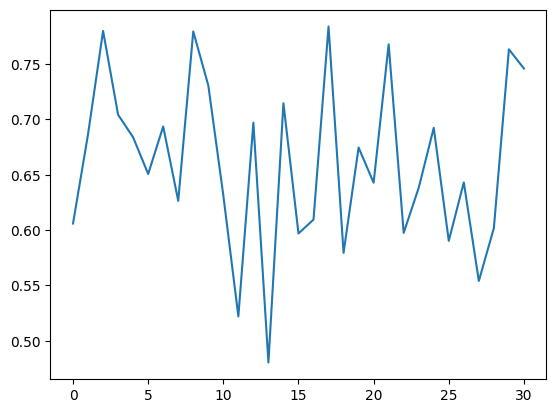

In [11]:
plt.plot([x.cpu().detach().numpy() for x in losses])

#### checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    # you can add more items to the checkpoint if needed, like epoch number, loss, etc.
}

torch.save(checkpoint, 'model_checkpoint_1.pth')


In [ ]:

# Evaluation
model.eval()
with torch.no_grad():
    # Prepare and normalize test data
    gap_test_features1 = global_average_pooling(test_features1)
    gap_test_features2 = global_average_pooling(test_features2)
    norm_test_features1 = normalize_features(gap_test_features1)
    norm_test_features2 = normalize_features(gap_test_features2)
    norm_test_relative_pos = normalize_positions(test_relative_pos)

    combined_test_features = torch.cat((norm_test_features1, norm_test_features2), dim=1)

    # Predict with the model
    predicted_norm_positions = model(combined_test_features)


In [18]:
len(test_point[0])

3

In [13]:
!nvidia-smi

Sun Dec 24 21:15:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   37C    P0               66W / 300W|  54577MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

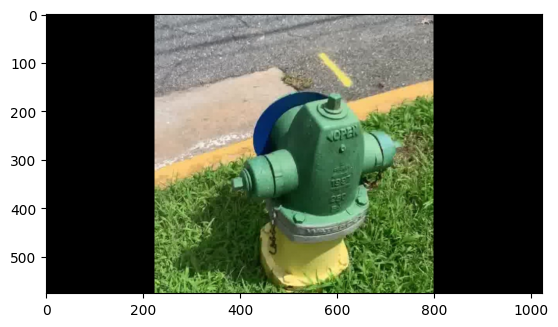

In [32]:
plt.imshow(test_point['image'][13].permute(1, 2, 0))